<table width="100%">
<tr>
    <td>
        <h1 style="text-align: left; font-size:300%;">
            DrugRepurposing
        </h1>
        <h1 style="text-align: left; font-size:150%;">
            Automated drug repurposing workflow for rare diseases – using Flask, Monarch API, DGIdb API and XGboost
        </h1> 
    </td>
    <td width="33%">
        <div style="text-align: right">
            <b> A GitHub repository by Niccolò Bianchi</b> <br>
            <a href="https://github.com/NCMBianchi/DrugRepurposing">github.com/NCMBianchi/DrugRepurposing</a><br>
            forked from Carmen Reep's and Nuria Queralt Rosinach's works<br>
        </div>
    </td>
</tr>
</table>

This notebook is meant to implement variations of the functions originally stored in the 'Monarch.py' file, in order to solve some of the issues that do not allow the tool to run.

Once a new pipeline is developed, a new version of the 'Monarch.py' file will be implemented. Step by step all other parts of the entire pipeline involving steps in 'DGIdb.py', 'drugsimilarity.py' and so on will be tested here as well.

![](./PIPELINE_images/github_header.png)

## 1. SETUP

The first step just returns the kernel and Python version to be sure about using the appropriate one -while also setting up some basic logging functions.

In [1]:
import sys,os,platform,datetime,logging,builtins,time,multiprocessing
python_executable = sys.executable
python_version = platform.python_version()
num_cores = multiprocessing.cpu_count()

# timestamp
today = datetime.date.today()
date_str = today.strftime('%Y-%m-%d')
curr_year = int(str(today)[:4])
overall_start_time = time.time()
formatted_start_time = datetime.datetime.now().strftime("%H:%M:%S")
print(f"'DrugRepurposing' pipeline started at {formatted_start_time}.\n")

# directory set-up
base_data_directory = os.path.join(os.getcwd(), 'drugapp', 'data')
today_directory = os.path.join(base_data_directory, date_str)
os.makedirs(today_directory, exist_ok=True)
disease_name_label = None
## just a placeholder: the aim is to replace it after running run_monarch_api()
## on the first seed

# logging configuration
platform_filename = "running_platform.txt"
platform_file_path = os.path.join(today_directory, platform_filename)
log_filename = "logfile.log"
log_file_path = os.path.join(today_directory, log_filename)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # highest level to capture all logs
file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.DEBUG)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.ERROR)  # only log errors to the console
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
if not logger.handlers:
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

def current_function_name():
    return inspect.currentframe().f_back.f_code.co_name

# 'w' instead of 'a' here to always overwrite when making a new run
with open(platform_file_path, 'w') as file:
    file.write(f"Python kernel: {python_executable}\n")
    file.write(f"Python version: {python_version}\n")
    file.write(f"The current machine has {num_cores} CPU cores.\n")
    file.write("\n\n")

print("Python kernel:", python_executable)
print("Python version:", python_version)
print(f"The current machine has {num_cores} CPU cores.")

'DrugRepurposing' pipeline started at 16:28:27.

Python kernel: /Users/ncmbianchi/miniconda3/bin/python3.11
Python version: 3.11.9
The current machine has 10 CPU cores.


The **list of packages** along with the version used is stored in the same *.txt* file where kernel location and version of Python written earlier.

In [2]:
# empty set to store the packages that will be imported:
imported_packages = {}
from importlib.metadata import version
from importlib import import_module

def import_and_log(*args):
    """
    Import a package or a component from a package and log it along 
    with its version immediately.
    """
    try:
        
        # Importing based on the number of arguments:
        # if 1 argument, 'import <arg_1>' (whole package)
        if len(args) == 1:
            package_name = args[0]
            package = import_module(package_name)
            imported_packages[package_name] = package
            setattr(builtins, package_name, package)  # globally available
            msg = f"Package '{package_name}' imported."
            
        # if 2 arguments, 'from <arg_1> import <arg_2>' (component from a package)
        elif len(args) == 2:
            package_name, component_name = args
            package = import_module(package_name)
            component = getattr(package, component_name)
            imported_packages[f"{package_name}.{component_name}"] = component
            setattr(builtins, component_name, component)  # globally available
            msg = f"Component '{component_name}' from package '{package_name}' imported."
        else:
            raise ValueError("Invalid number of arguments passed to import_and_log().")
        
        print(msg)  # Print import confirmation
        log_imports_and_versions(msg)  # Log the import and its version
        
    except ImportError as e:
        print(f"Failed to import {args}. Error: {e}")
    except AttributeError as e:
        print(f"Component '{args[1]}' not found in package '{args[0]}'. Error: {e}")

def log_imports_and_versions(message):
    """
    Append import messages and version information of the most
    recently imported package to a file.
    """
    with open(platform_file_path, 'a') as file:
        # Write the message about what was just imported
        file.write(f"{message} ")
        
        # Identify the last imported package or component
        if imported_packages:
            full_name = list(imported_packages.keys())[-1]  # Get the last key in the dictionary
            package_name = full_name.split('.')[0]  # Only use the top-level package name for version retrieval
            try:
                if package_name == 'sklearn':
                    package_name = 'scikit-learn'
                pkg_version = version(package_name)
                version_info = f"(version: {pkg_version})"
            except Exception as e:
                version_info = f"(version not found for {package_name}: {e})"
            
            # Write the latest version info to the file and print it
            file.write(f"{version_info}\n\n")
            print(version_info)

In [3]:
import tqdm
import re
import json  # to save .json files returned by the API
import logging  # to check for running variables
import inspect  # to chec for running functions
import shutil  # to properly copy and rename files in run_monarch_mock()
import ast  # for syntax trees in 'DGIdb.py' steps
from unittest.mock import Mock  # to reverse requests.Response()
import pickle

# only non-core packages are loaded with the 'import_and_log()' function:
import_and_log('pandas')  # for general object handling
import_and_log('numpy')  # for general operations
import_and_log('requests')  # for several API calls
import_and_log('networkx')  # for ' Monarch.py' to plot the network
import_and_log('matplotlib')  # for ' Monarch.py' to plot the network
import_and_log('biothings_client','get_client') # for several API calls
import_and_log('rdkit','Chem')  # for 'drugsimilarity.py'
import_and_log('rdkit','RDLogger')  # for 'drugsimilarity.py'
import_and_log('rdkit','DataStructs')  # for 'drugsimilarity.py'
import_and_log('SPARQLWrapper','SPARQLWrapper') # for 'drugsimilarity.py' (NEW)
import_and_log('SPARQLWrapper','JSON') # for 'drugsimilarity.py' (NEW)
import_and_log('node2vec','Node2Vec')  # for 'network_model.py'
import_and_log('sklearn')  # for 'network_model.py'
import_and_log('xgboost','XGBClassifier')  # for 'network_model.py'
import_and_log('scipy','stats')  # for 'network_model.py'
import_and_log('IPython','display')  # for 'network_model.py'

# for ease of use, some packages are reloaded with an alias
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
mc = get_client('chem')

# these submodules are imported normally as the main versions are already logged,
# and importlib.import_module() doesn't handle well submodules
from rdkit.Chem import AllChem  # older version, do not place in REQUIREMENTS.txt
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator # instead of AllChem
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from scipy.stats import uniform
from IPython.display import HTML

## REMEMBER that 'sklearn' is used to call the package otherwise installed as
## 'scikit-learn': the old PyPi 'sklearn' is deprecated 

Package 'pandas' imported.
(version: 2.1.2)
Package 'numpy' imported.
(version: 1.26.4)
Package 'requests' imported.
(version: 2.31.0)
Package 'networkx' imported.
(version: 2.8.8)
Package 'matplotlib' imported.
(version: 3.8.0)
Component 'get_client' from package 'biothings_client' imported.
(version: 0.3.1)
Component 'Chem' from package 'rdkit' imported.
(version: 2024.3.1)
Component 'RDLogger' from package 'rdkit' imported.
(version: 2024.3.1)
Component 'DataStructs' from package 'rdkit' imported.
(version: 2024.3.1)
Component 'SPARQLWrapper' from package 'SPARQLWrapper' imported.
(version: 2.0.0)
Component 'JSON' from package 'SPARQLWrapper' imported.
(version: 2.0.0)


/Users/ncmbianchi/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Component 'Node2Vec' from package 'node2vec' imported.
(version: 0.4.6)
Package 'sklearn' imported.
(version: 1.4.2)
Component 'XGBClassifier' from package 'xgboost' imported.
(version: 2.0.3)
Component 'stats' from package 'scipy' imported.
(version: 1.12.0)
Component 'display' from package 'IPython' imported.
(version: 8.23.0)


## 2. ```MONARCH.py```: BIOLOGICAL ASSOCIATIONS

First let's set-up the function used to make API calls.

**Paths are currently set starting outside the drugapp directory, while later when implemented as .py scripts, paths will be adapted a bit.**

In [4]:
def hit_monarch_api(seed = 'MONDO:0007739', rows = 2000):
    """
    Originally part of NQR's "bioknowledgeReviewer" tool.
    
    This function performs API calls to Monarch to retrieve 'OUT' and 'IN' edges from a query node.
    It retrieves entities plus associations via the Monarch Initiative new V3 API (2023 onward).
    
    The original version used the older Biolink API, no longer supported:
    https://api-biolink.monarchinitiative.org/api/association
     
    Moreover:
       - Biolink supported 'OMIM:' URIs, V3 doesn't and 'MONDO:' is used
       - Biolink required 'association/____', V3 requires 'association?____='
       - Biolink supported the ":" character, V3 requires its ASCII version (i.e.%3A)
       
    It hits two endpoints:
       - association?subject= (for 'OUT' edges)
       - association?object= (for 'IN' edges)
    It returns 'OUT' and 'IN' edges.

    :param node: node ID to query (string). Default: 'MONDO:0007739' (=Huntington Disease).
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :return: two API response objects: 'OUT' and 'IN' response objects, in this order.
    """
    
    logging.info(f"NOW RUNNING: {current_function_name()} with seed {seed}.")

    # API address
    biolink = 'https://api-v3.monarchinitiative.org/v3/api/association'  #V3
    seed_new = seed.split(':')
    seed_call = seed_new[0]+'%3A'+seed_new[1]

    # parameters
    parameters = {'fl_excludes_evidence': False, 'rows': rows}

    # OUT edges API call  ('?subject=')
    out_url = f'{biolink}?subject={seed_call}'
    r_out = requests.get(out_url, params=parameters)  # API call
    logging.info(f"Out edges request URL: {out_url} with parameters {parameters}")
    logging.info(f"Out edges response status: {r_out.status_code}")

    # IN edges API call (?object=)
    in_url = f'{biolink}?object={seed_call}'
    r_in = requests.get(in_url, params=parameters)  # API call
    logging.info(f"In edges request URL: {in_url} with parameters {parameters}")
    logging.info(f"In edges response status: {r_in.status_code}")

    # Error Handling for API responses
    if not r_out.ok or not r_in.ok:
        error_message = f"Error fetching data for seed {seed}: OUT status {r_out.status_code}, IN status {r_in.status_code}"
        logging.error(error_message)
        # Handle error appropriately, could raise an exception or return an error code
        raise Exception(error_message)
    
    # (eventually) create disease directory
    r_out_json = r_out.json()
    r_in_json = r_in.json()
    if seed == input_seed[0]:
        if 'items' in r_out_json and r_out_json['items']:   # identify 'name' and 'id'
            disease_name = r_out_json['items'][0]['subject_label']
            disease_id = r_out_json['items'][0]['subject']
        else:
            logging.warning("Warning: 'associations' key not found in response or no associations present.")
            return None, None
        disease_directory = os.path.join(today_directory, f'{disease_name} ({date_str})')
        os.makedirs(disease_directory, exist_ok=True)  # the date is repeated just for archival purposes
        disease_id_file_path = os.path.join(disease_directory, 'disease_id.txt')
        with open(disease_id_file_path, "w") as text_file:
            
            # store 'disease_name' and 'disease_id'
            text_file.write(f"{disease_id};{disease_name}\n")
            
            # store the list of subject closure for the input_seed
            # (information on the ontology of the disease)
            text_file.write(f"Subject closure:{r_out_json['items'][0]['subject_closure']}")
            logging.info(f"Information on the disease saved to {disease_id_file_path}")
            
    else:
        disease_id = disease_id_label
        disease_name = disease_name_label
        disease_directory = os.path.join(today_directory, f'{disease_name} ({date_str})')
    monarch_directory = os.path.join(disease_directory, 'monarch')
    seed_new = seed.split(':')
    seed_dir = seed_new[0]+'_'+seed_new[1]
    seed_directory = os.path.join(monarch_directory, seed_dir)
    os.makedirs(seed_directory, exist_ok=True)
    
    # store OUT .json file
    out_file_path = os.path.join(seed_directory, f'{seed_dir}_api_response_OUT.json')
    if r_out.ok:
        with open(out_file_path, 'w') as json_file:
            json.dump(r_out_json, json_file)
        logging.info(f"API response saved to {out_file_path}")
    else:
        logging.error(f"Failed to fetch OUT edges: {r_out.status_code} - {r_out.reason}")

    # store IN .json file
    in_file_path = os.path.join(seed_directory, f'{seed_dir}_api_response_IN.json')
    if r_in.ok:
        with open(in_file_path, 'w') as json_file:
            json.dump(r_in_json, json_file)
        logging.info(f"API response saved to {in_file_path}")
    else:
        logging.error(f"Failed to fetch IN edges: {r_in.status_code} - {r_in.reason}")
    
    return r_out, r_in, disease_id, disease_name

In [5]:
input_seed = ['MONDO:0007739']
r_out, r_in, disease_id_label, disease_name_label = hit_monarch_api()
print(r_out)

<Response [200]>


The test-run above uses a hardcoded variable for 'MONDO:0007739' URI identifier for Huntington's disease –but let's assume that in the actual pipeline it uses variable ```input``` provided by the flaskApp.

**Status ```<Response [200]>``` means that the http-request went fine.**

Files are stored according to this tree like structure:

![](./PIPELINE_images/json_tree.png)

Any subsequent run of ```hit_monarch_api()``` doesn't create new subdirectories -if in the same pipeline- while instead storing .json files within the same **.../YYYY-MM-DD/disease YYYY-MM-DD/monarch** directory.

Variables ```disease_id_label``` and ```disease_name_label``` are always returned in order to store as global variables information required for path buildings in some of the functions.

Objects ```r_out``` and ```r_in``` that are returned contain the .json output as a single string.

Then let's define the function that builds the first layer of neighbours and relations: my intention is to make a new version that can handle both one single seed (as in the first layer) or a list of seeds (as in the second and third layer), while also checking if the call for those given sees has already been run: if not, it runs ```hit_monarch_api()``` again; otherwise it retrieves data from the directory corresponding with that seed ID.

In [6]:
def unique_elements(nonUnique_list):
    """
    Short function that remove duplicate elements.
    If the list contains nodes, it will simply convert it into a set{}.
    If the list contains edges, it will remove also edges where subject and object
    are inverted, therefore not being recognised as the same by Python.

    :param nonUnique_list: biomedical entities list, where each entity is either a
    node or an edge in association networks
    :return: list of the same biomedical entities without duplicates
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed list {nonUnique_list[:2]}.")
    logging.info(f"Initial list size: {len(nonUnique_list)}")
    
    # if nonUnique_list is empty
    if not nonUnique_list:
        return []
    
    if isinstance(nonUnique_list[0], dict):
        # Handle list of nodes
        nodes_set = set(tuple(sorted(node.items())) for node in nonUnique_list)
        unique_list = [dict(node) for node in nodes_set]

    elif len(nonUnique_list[0]) == 4 and isinstance(nonUnique_list[0], list):
        # Handle list of edges
        unique_list = []
        seen_edges = set()
        for edge in nonUnique_list:
            subj_id = edge[0]['id']
            obj_id = edge[2]['id']
            norm_edge = tuple(sorted([subj_id, obj_id]))
            if norm_edge not in seen_edges:

                # locally store the simplified/normalised edge for parsing
                seen_edges.add(norm_edge)

                # return the actual full edge
                unique_list.append(edge)
                
    else:
        raise ValueError("Input is not recognised.")

    logging.info(f"Final list size: {len(unique_list)} ({len(nonUnique_list)-len(unique_list)} removed)")
    
    return unique_list


def json_reverse(json_dict):
    """
    Short function that converts calls turned into JSON files by the json() function
    into a request.Response object

    :param seed_list: JSON response stored as a dictionary
    :return: Mock object mimicking requests.Response with the provided JSON data.
    """
    
    json_file = Mock()
    json_file.json.return_value = json_dict
    json_file.status_code = 200
    json_file.ok = True

    return json_file


def get_neighbours(seed_list,layer):
    """
    Originally part of NQR's "bioknowledgeReviewer" tool.
    
    This function parses through the .json files obtained from the hit_monarch_api()
    function, in order to obtain nodes that are related to any seed provided.
    
    If the API call for a given seed has already been run –and therefore a directory
    named with the same URI is present in
    ~/drugapp/data/YYYY-MM-DD/disease YYYY-MM-DD/monarch– then relevant information
    are fetched from the already locally stored 'URI_api_response_OUT.json' and
    'URI_api_response_IN.json' files. This allows for a reduced overhead.

    Information regarding subject, relation and object for both the 'OUT' and 'IN' calls
    are then stored in a table with a noSQL approach (?).

    :param seed_list: biomedical entities list, where each entity is a URI
    identifier string such as 'MONDO:0007739' or 'HGNC:4851'
    :return: neighbours list
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed list {seed_list}.")

    # create the object that will store all the associations found while parsing
    # through the .json file ouputs from hit_monarch_api()
    edges_list = list()
    nodes_list = list()
    global disease_name_label
    global disease_id_label

    # iterate through each seed
    for seed in seed_list:
        seed_new = seed.split(':')
        seed_dir = seed_new[0]+'_'+seed_new[1]
        seed_path = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'monarch', seed_dir)
        
        # run API calls (OUT and IN) for the given seed in the 'FOR' loop
        if os.path.exists(seed_path):
            out_json_path = os.path.join(seed_path, f'{seed_dir}_api_response_OUT.json')
            in_json_path = os.path.join(seed_path, f'{seed_dir}_api_response_IN.json')
            with open(out_json_path, 'r') as file:
                r_out_json = json.load(file)
            with open(in_json_path, 'r') as file:
                r_in_json = json.load(file)
            r_out = json_reverse(r_out_json)
            r_in = json_reverse(r_in_json)
            logging.info(f"API call for {seed} already performed. Files fetched from {seed_path}.")
        else:
            r_out, r_in, disease_id_label, disease_name_label = hit_monarch_api(seed)
        
        # .json file handling
        for associations in [r_out.json()['items'], r_in.json()['items']]:
            for association in associations:
                
                # parse through the files and store the associations in edges_list
                subj = {'id': association['subject'], 'label': association['subject_label']}
                rel = {'label': association['predicate']} # relation ID no longer present
                obj = {'id': association['object'], 'label': association['object_label']}
                notes = {'notes': layer}
                ## reference (link to literature) no longer present
                association_elem = [subj, rel, obj, notes]
                edges_list.append(association_elem)

                # extrapolate list of nodes (both subjects and objects) and store it in nodes_list
                nodes_list.append(subj)
                nodes_list.append(obj)

    # filter for only unique nodes and edges
    nodes_list = unique_elements(nodes_list)
    edges_list = unique_elements(edges_list)

    logging.info(f"Sample of nodes (20): {nodes_list[:20]})")
    logging.info(f"Sample of edges (10): {edges_list[:10]})")
    
    # to fill in - and ADD LOG LINES
    return nodes_list, edges_list, disease_id_label, disease_name_label

![](./PIPELINE_images/csv_columns.png)

Above the columns in the original output's from CR's and NQR's codes.

Their original version was structured so that function ```get_neighbours_list()``` (input = seed list; output = list of neighbours) would call function ```get_neighbours()``` (input = seed list; output = set of neighbour nodes, set of neigbour edges) for each of the nodes in the list.

Within that:

1) The ```hit_monarch_api()``` function (input = node seed; output = r_out, r_in) would be run for:
- the disease id if this is the first layer (single seed)
- each of the node seeds in the second and third layer (multiple seeds)

All following steps are part of the same iteration.

2) The resulting ```r_out``` and ```r_in``` (i.e. response objects containing information in the API .json ouput) would then be parsed by ```get_edges_objects()``` (input = r_out, r_in; output = lists of subjects, relations, objects and references) to obtain information required to build edges –as well as links to publications. This step parses through each of the associations returned by the Monarch Initiative API by considering each of the ```items``` elements in both ```r_out.json()``` and ```r_in.json()``` one after the other to then extrapolate information corresponding to certain labels:
   - ```association['subject']``` for the subject id, and ```association['subject_label']``` for its label
   - ```association['predicate']``` for the relation id and label (duplicate)
   - ```association['object']``` for the object id, and ```association['object_label']``` for its label
   - ```association['publications']``` for the link to an annotated publication, if present
<br>
3) The edges are then obtained by running function ```get_edges()``` (input = lists of subjects, relations, objects and reference, and 'id' flag; output = set of list of edges), which iterates through elements in list of subjects –all lists from ```get_edges_objects()``` are the same lenght– to build a set of lists (of dictionaries) that can be summarised as this: **{('Subject1', 'hasPhenotype', 'Object1', 'Ref1'), ('Subject2', 'isOrthologOf', 'Object2', 'Ref2')}**.

After these steps, the original code ran a few data allocation steps:

4) Function ```keep_edges()``` (input = empty set of edges, edges dataframe ; output = set of edges) handles the edges in a Python set{} to only store unique edges and have no duplicates. The resulting set would only contain unique edges by adding edges at each iteration of ```get_neighbours()``` within ```get_neighbours_list()```.
5) Function ```keep_nodes()``` (input = empty set of nodes, edges dataframe, set of seed nodes; output = set of nodes) takes into account the set obtained by the seed list as input for the ```get_neighbours()``` mother function. The result is the same as in keep_edges() a set of unique nodes, where nodes are added at each iteration.

I made a ```unique_element()``` function that takes arguments with either dict-tuples (*i.e.* (id:label)) or lists of three items as elements. Based on the context whether nodes or edges it uses the correct approach –but since it's a very similar operation one function only is enough at this point. The original separate version would anyway be available in older **```2024.0.__```** commits (currently in ```2024.1.__```). This function still makes sense as a standalone as it's very self-contained and would be used again later steps.

This original version contemplated several sub-functions as they would also be used by macro-function ```get_orthopheno_list()``` (input = seed list; ouput = node list) which would also add a ```keep_node_type()``` step (input = edge list, seed list; ouput = __ of orthologs/phenotypes) that filters edges based on object nodes that only correspond to certain relational ontology type (i.e. RO: -either ortholog genes or phenotypes). Such step would be performed twice after each of two rounds of ```get_neighbours()```, once per ontology type. This is meant in order to have only phenotypes in the second layer, and ortholog genes in the third one.  

These were some of the steps that would cause the most issues and prevent the tool from running, as they would filter out all edges for not meeting the identity requirements above. Moreover, they seemed conceptually unnecessary –if not wrong.

![](./PIPELINE_images/flowchart.png)

**My version of the code takes another approach**: by allowing it to perform each of the three layer steps we can avoid having too many functions –as they would not be re-used elsewhere.

The overall function is still not overly complicated though thanks to focusing on **'IF' gates** that allow for slight changes in operation.

This also allows to already store all information relevant for the **list of nodes** and **list of edges** that are the final outputs of the entire *Monarch.py* original script: I want to mantain the same data structure to then re-implement the original following steps.

The original code also contempletated a **get_connections(nodes)** step that would fetch by subsequent (redundant) calls information on the nodes in the list. At some point a ```filter_edges()``` (input = list of nodes, list of edges; output = list of filtered edges) function, to only keep edges where both subject and object node are part of the node list outputed by each.

This step seemed unnecessary to me, so I skipped it.

Below a test run of the ```get_neibours()``` function:

In [7]:
input_seed = ['MONDO:0007739']  # required as a list
firstLayer_nodes, firstLayer_edges, disease_id_label, disease_name_label = get_neighbours(input_seed,'first_layer')

Below a test to see how many elements are returned from the first run. Apparently both would return 32 elements, which is weird as I would expected ```nodes-1``` edges, as one of the nodes would be the initial input seed 'MONDO:0007739'.

In [8]:
print(len(firstLayer_nodes))

29


In [9]:
print(len(firstLayer_edges))

29


In [10]:
edges_without_mondo = [edge for edge in firstLayer_edges if not (edge[0].get('id', '') == 'MONDO:0007739' or edge[2].get('id', '') == 'MONDO:0007739')]
edges_without_mondo[:1]

[[{'id': 'MONDO:0016621', 'label': 'juvenile Huntington disease'},
  {'label': 'biolink:has_phenotype'},
  {'id': 'HP:0000708', 'label': 'Atypical behavior'},
  {'notes': 'first_layer'}]]

Turns out that the extra edge comes from I guess the API considers as an 'alias' of 'MONDO:0007739': **'MONDO:0016621'**, which is the juvenile version of HD.

I will not add a step that filters this edge out as:
1) this edge is still relevant
2) I assume the API would never return edges that are not meaningful
   

In [11]:
edges_with_mondo_both = [edge for edge in firstLayer_edges if edge[0].get('id', '') == 'MONDO:0007739' and edge[2].get('id', '') == 'MONDO:0007739']
edges_with_mondo_both

[]

Below instead the final function for the ***Monarch.py*** step: this function summaries both ```run_monarch()``` and ```run_monarch_symptoms()``` functions from CR's original code: her flaskApp meant to ask to the user for the selection of one symptom only on which to build the network. I tried bypassing that and checking how much longer it would take to check for ALL symptoms (*i.e.* first layer of phenotypes).

In [12]:
def run_monarch(input_id = 'MONDO:0007739'):
    """
    This function runs the whole Monarch script and saves nodes and edges files.

    :param input_number: The input MONDO: URI  of the disease
    :return: nodes and edges files in /monarch folder
    """
    
    logging.info(f"NOW RUNNING: {current_function_name()} with seed {input_id}.")

    start_time = time.time()
    
    # First layer: use the flaskApp input
    firstLayer_nodes, firstLayer_edges, disease_id_label, disease_name_label = get_neighbours(input_id,'first_layer')

    # Second layer: use the nodes in the first layer
    firstLayer_seeds = [item['id'] for item in firstLayer_nodes]  # turn into a list of IDs
    firstLayer_seeds = [fl_id for fl_id in firstLayer_seeds if fl_id not in input_id]  # to avoid re-running nodes and counting them in the second layer
    secondLayer_nodes, secondLayer_edges, disease_id_label, disease_name_label = get_neighbours(firstLayer_seeds,'second_layer')

    # Third layer: use the nodes in the second layer
    secondLayer_seeds = [item['id'] for item in secondLayer_nodes]  # turn into a list of IDs
    secondLayer_seeds = [sl_id for sl_id in secondLayer_seeds if sl_id not in firstLayer_seeds]  # to avoid re-running nodes and counting them in the third layer
    thirdLayer_nodes, thirdLayer_edges, disease_id_label, disease_name_label = get_neighbours(secondLayer_seeds,'third_layer')
    
    # MERGE the nodes' lists
    nonUnique_nodes = firstLayer_nodes + secondLayer_nodes + thirdLayer_nodes
    unique_nodes = unique_elements(nonUnique_nodes)
    
    # MERGE the edges' lists
    nonUnique_edges = firstLayer_edges + secondLayer_edges + thirdLayer_edges
    unique_edges = unique_elements(nonUnique_edges)
    
    # save the unique nodes and edges as CSV
    monarch_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'monarch')
    nodes_df = pd.DataFrame(unique_nodes)
    nodes_df.to_csv(os.path.join(monarch_directory, f'{disease_name_label}_{date_str}_monarch_nodes.csv'), index=False)
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(monarch_directory, f'{disease_name_label}_{date_str}_monarch_edges.csv'), index=False)

    logging.info("CSV files saved in Monarch directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"'Monarch.py' run finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"'Monarch.py' run finished in {minutes} minutes and {seconds} seconds.")
    
    return unique_nodes, unique_edges, disease_id_label, disease_name_label

In [13]:
input_seed = ['MONDO:0007739']  # required as a list
nodes, edges, disease_name_id, disease_name_label = run_monarch(input_seed)

'Monarch.py' run finished in 0 minutes and 0 seconds.


**I ran the code above**: it made 594 unique calls (65MB dowloaded in 18min with a not-so-great connection): all duplicate calls were skipped. By loading locally stored API calls' .json files runtime reduces to 3sec.

Below the number of edges and nodes in the 3-layered network for Huntington Disease.

In [14]:
len(edges)

12726

In [15]:
len(nodes)

7375

My next steps are:
- **checking which of the node types might be un-necessary for this purpose** so that they can be ignored ahead of making API calls, to save time
- attempting a data-visualisation line to show the network clusters (at least for the purpose of my thesis)

Above all the URI types found within these three layers:
- NCBItaxon: Taxonomic data from the NCBI Taxonomy database, used for species
- FB: FlyBase identifier for Drosophila genes and genetic information
- MGI: Mouse Genome Informatics for mouse genetic information
- Xenbase: Xenopus biology database for African clawed frog genetic and developmental data
- **MP**: Mammalian Phenotype Ontology, describing phenotypic abnormalities in mammals
- **CL**: Cell Ontology, used for cell type definitions
- SGD: Saccharomyces Genome Database for yeast genetics and biology
- ZFIN: Zebrafish Information Network for zebrafish genetic and developmental information
- dictyBase: Resource for Dictyostelid species genetics and cell biology
- **CHEBI**: Chemical Entities of Biological Interest, a database of molecular entities focused on 'small' chemical compounds
- PomBase: Resource for genetic information on the fission yeast Schizosaccharomyces pombe
- ECTO: Exposure Ontology, describing types of exposure to environmental entities
- **CHR**: Chromosome Ontology, for specifying chromosome parts and structures
- PATO: Phenotypic Quality Ontology, describing how phenotypes are qualitatively altered
- **NCBIgene**: Gene identifiers from the NCBI gene database
- WB: WormBase, providing genetic and biological data for Caenorhabditis elegans and related nematodes
- **SO**: Sequence Ontology, which provides a set of terms and relationships used to describe the features and attributes of biological sequence
- **GO**: Gene Ontology, provides a controlled vocabulary to describe gene and gene product attributes in any organism
- **OBA**: Ontology for Biomedical Associations, used to specify associations in biomedical contexts
- **UPHENO**: Unified Phenotype Ontology, integrating multiple phenotype ontologies across different species
- RGD: Rat Genome Database, provides genetic and phenotypic data for Rattus norvegicus
- **HP**: Human Phenotype Ontology, describing phenotypic abnormalities found in human disease
- **HGNC**: HUGO Gene Nomenclature Committee, providing a unique identifier for human genes
- PR: Protein Ontology, provides structured classification of proteins and their relationships
- UBERON: Multi-species anatomy ontology, covering anatomical structures in multiple animal species
- **MONDO**: Monarch Disease Ontology, integrates multiple sources of disease data to provide unified disease definitions
- **Reactome**: A database of reactions, pathways, and biological processes

In **bold** those I deem relevant candidates, although probably only ```HGNC:``` and ```HP:``` should be considered respectively for genes and phenotypes. 

In [16]:
URI_counts = {}
for node in nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0]
        if URI in URI_counts:
            URI_counts[URI] += 1
        else:
            URI_counts[URI] = 1
print(URI_counts)

{'HGNC': 3020, 'MONDO': 1332, 'PATO': 6, 'GO': 323, 'HP': 1342, 'NCBIGene': 118, 'MGI': 117, 'CHEBI': 578, 'WB': 64, 'FB': 47, 'UBERON': 107, 'ZFIN': 42, 'UPHENO': 66, 'Reactome': 102, 'RGD': 46, 'MP': 4, 'CL': 12, 'NCBITaxon': 9, 'SGD': 3, 'Xenbase': 14, 'PomBase': 5, 'dictyBase': 7, 'ECTO': 3, 'PR': 4, 'CHR': 2, 'OBA': 1, 'SO': 1}


In comparison CR's output for nodes has this URI distribution:

In [17]:
URI_counts = {}
CR_df = pd.read_csv('./drugapp/data/reference/Huntington disease (2022-06-27)/monarch/monarch_nodes_disease_v2022-06-27.csv')
if 'id' in CR_df.columns:
    CR_nodes = CR_df['id'].tolist()
for node in CR_nodes:
    URI = node.split(':')[0]
    if URI in URI_counts:
        URI_counts[URI] += 1
    else:
        URI_counts[URI] = 1
print(URI_counts)

{'MGI': 84, 'MONDO': 2, 'HGNC': 17, 'HP': 68, 'dbSNPIndividual': 9, 'ClinVarVariant': 3, 'REACT': 1, 'dbSNP': 22, 'ENSEMBL': 4, 'WormBase': 2, 'ZFIN': 4, 'FlyBase': 2}


The current version of the code will keep all nodes currently found, although changes in the code by accessing other tools in the API (*e.g.* ```v3/api/entity/{id}/{category}``` to only find associations to a given seed –both IN and OUT– that correspond to a certain category, such as 'phenotype') and **filtering only for certain categories** –and not just certain URIs– **at each layer**.

This could be done by implementing a whitelist of accepted URIs –or a blacklist of discarded ones. So far we will keep all of them to have the widest array of information of possible. In the end the information we require are in nodes with URI ```MONDO:```, ```HGNC:``` and ```HP:```, but by having also other URIs when building the three layer we can reach certain genes and phenotypes that would always not directly associate.

The full representation of the graph would be complete, but not highly readable. Below the graph for layers 1 and 2  only (takes a few seconds):

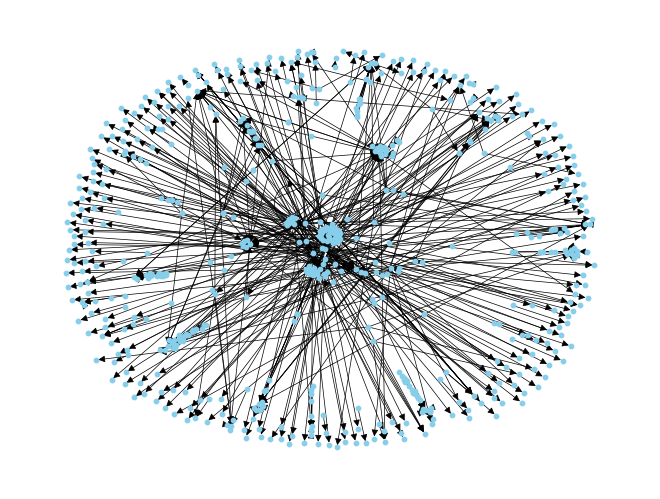

In [18]:
G = nx.DiGraph()
twolayer_edges = [edge for edge in edges if 'first_layer' in edge[3]['notes'] or 'second_layer' in edge[3]['notes']]
for edge in twolayer_edges:  # to run the full graph, use 'edges' instead of the subset
    subj_id = edge[0]['id']
    obj_id = edge[2]['id']
    rel_label = edge[1]['label']
    G.add_edge(subj_id, obj_id, label=rel_label)

pos = nx.spring_layout(G)
labels = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_color='skyblue',
        node_size=10, edge_color='k', width=0.5)
plt.show()

**If necessary the code can be modified to use different colours for different types of nodes and edges.**

The code assumes (also based on the [*Putman et al. 2023* paper](https://pubmed.ncbi.nlm.nih.gov/38000386/)) that between any two nodes there only is one kind of relation.

![](./PIPELINE_images/monarch-sem_model.jpg)

Below we can see all labels found ahead of filtering for unique edges:

In [19]:
input_seed = ['MONDO:0007739']  # required as a list
firstLayer_nodes, firstLayer_edges, disease_id_label, disease_name_label = get_neighbours(input_seed,'first_layer')
firstLayer_seeds = [item['id'] for item in firstLayer_nodes]  # turn into a list of IDs
firstLayer_seeds = [fl_id for fl_id in firstLayer_seeds if fl_id not in input_seed]  # to avoid re-running nodes and counting them in the second layer
secondLayer_nodes, secondLayer_edges, disease_id_label, disease_name_label = get_neighbours(firstLayer_seeds,'second_layer')
nonUnique_edges = firstLayer_edges + secondLayer_edges

In [20]:
nonUnique_relation_counts = {}
for edge in nonUnique_edges:
    relation_dict = edge[1]
    if 'label' in relation_dict:
        relation = relation_dict['label']
        if relation in nonUnique_relation_counts:
            nonUnique_relation_counts[relation] += 1
        else:
            nonUnique_relation_counts[relation] = 1
print(nonUnique_relation_counts)

{'biolink:has_mode_of_inheritance': 45, 'biolink:subclass_of': 153, 'biolink:related_to': 44, 'biolink:has_phenotype': 224, 'biolink:causes': 12, 'biolink:gene_associated_with_condition': 41, 'biolink:treats_or_applied_or_studied_to_treat': 55, 'biolink:interacts_with': 51, 'biolink:enables': 4, 'biolink:actively_involved_in': 4, 'biolink:located_in': 4, 'biolink:participates_in': 42}


Above you can see all types of relations found. Let's then identify another ID that comes up several times, and use it as a case study:

In [21]:
nonUnique_node_counts = {}
for edge in nonUnique_edges:
    subj_id = edge[0]['id']
    obj_id = edge[2]['id']
    if subj_id in nonUnique_node_counts:
        nonUnique_node_counts[subj_id] += 1
    else:
        nonUnique_node_counts[subj_id] = 1
    if obj_id in nonUnique_node_counts:
        nonUnique_node_counts[obj_id] += 1
    else:
        nonUnique_node_counts[obj_id] = 1

threshold = 30
reference_seeds = [node for node, count in nonUnique_node_counts.items() if count > threshold]
print("Reference seeds based on threshold:")
for seed in reference_seeds:
    print(seed)

Reference seeds based on threshold:
HP:0000006
MONDO:0016621
HGNC:4851
HGNC:11007


In [22]:
nonUnique_filtered_edges = []
for edge in nonUnique_edges:
    subj_id = edge[0]['id']
    obj_id = edge[2]['id']
    if (subj_id in input_seed and obj_id in reference_seeds) or (subj_id in reference_seeds and obj_id in input_seed):
        nonUnique_filtered_edges.append(edge)

for edge in nonUnique_filtered_edges:
    print(f"{edge}\n")
print (f"Edges' count: {len(nonUnique_filtered_edges)}")

[{'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'label': 'biolink:has_mode_of_inheritance'}, {'id': 'HP:0000006', 'label': 'Autosomal dominant inheritance'}, {'notes': 'first_layer'}]

[{'id': 'MONDO:0016621', 'label': 'juvenile Huntington disease'}, {'label': 'biolink:subclass_of'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

[{'id': 'HGNC:4851', 'label': 'HTT'}, {'label': 'biolink:causes'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

[{'id': 'HGNC:11007', 'label': 'SLC2A3'}, {'label': 'biolink:gene_associated_with_condition'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

[{'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'label': 'biolink:has_mode_of_inheritance'}, {'id': 'HP:0000006', 'label': 'Autosomal dominant inheritance'}, {'notes': 'second_layer'}]

[{'id': 'HGNC:4851', 'label': 'HTT'}, {'label': 'biolink:causes'}, {'id': 'MONDO:0007739', 'label'

Above we can see all edges with node ```MONDO:0007739``` (*i.e.* the original input seed for the disease of interest) as either subject or object, and any of the most recurring nodes as the other element in the edge.

In [23]:
unique_edges = unique_elements(nonUnique_edges)

In [24]:
unique_filtered_edges = []
for edge in unique_edges:
    subj_id = edge[0]['id']
    obj_id = edge[2]['id']
    if (subj_id in input_seed and obj_id in reference_seeds) or (subj_id in reference_seeds and obj_id in input_seed):
        unique_filtered_edges.append(edge)

for edge in unique_filtered_edges:
    print(f"{edge}\n")
print (f"Edges' count: {len(unique_filtered_edges)}")

[{'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'label': 'biolink:has_mode_of_inheritance'}, {'id': 'HP:0000006', 'label': 'Autosomal dominant inheritance'}, {'notes': 'first_layer'}]

[{'id': 'MONDO:0016621', 'label': 'juvenile Huntington disease'}, {'label': 'biolink:subclass_of'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

[{'id': 'HGNC:4851', 'label': 'HTT'}, {'label': 'biolink:causes'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

[{'id': 'HGNC:11007', 'label': 'SLC2A3'}, {'label': 'biolink:gene_associated_with_condition'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'first_layer'}]

Edges' count: 4


The results proves that at least up to the second layer –**further checks can be done when also considering the third layer**– no more than one relation is present for each couple of nodes, as the same relation will be returned twice when calling for the subject or object: edges in fact go from n to >n/2. I tested it with n=8 due to ```threshold = 30```, but also with n= 20 with ```threshold = 20``` with counts after filtering respectively 4 and 14.

By never being less than half of the original number, we can assume there never are more edges removed. **If necessary we can add a step that reports for each edge, how many are removed as non-unique.**

## 3. ```DGIdb.py```: GENE-TO-DRUG ASSOCIATIONS

This section **matches genes** in the nodes obtained from the previous steps **to drugs** via the DGIdb (*i.e* Drug-gene interaction database).

CR's original version would load the dataframe for the edges from the .csv files created in the previous step based on the current date alone –I instead changed the main ```run_dgidb()``` (input = date; output = lists of nodes and edges matched with drugs) function so that it takes both input seed and date to determine which folder to access.

The nodes list is then parsed through the ```get_genes()``` (input = full nodes list; output = gene-only nodes list) function that retrieves the list of genes only –based on the condition for URIs to contain 'HGNC:' and few other ontologies. Then the list of gene-only node is matched against the ENTREZ database (*i.e.* ```normlize_genes_to_graph()``` (input = gene-only node list; output = same list with ENTREZ ids)) to use that as a seed for DGIdb via ```hit_dgidb_api()``` (input = gene-id list; output = gene-to-drug edges list).

![](./PIPELINE_images/dgidb.png)

Finally the resulting list of edges with information from both Monarch and DGIdb APIs would be converted in a dictionary, stored as an intermediate to then make new calls to add metadata –a step which I completely skipped again as many errors would arise and such information are not necessary at this point. 

My approach focuses instead on first building the **```hit_dgidb_api()```** to make calls for one node at a time –node that belongs to category ```gene```. Therefore it would return the corresponding association edges for drugs related to that given gene.

In [25]:
def get_entrez(nonENTREZ_seed):
    """
    This function performs API calls to DGIdb to retrieve OUT and IN edges
    from a query node (i.e. gene).

    :param ENTREZ_seed: single ENTREZ ID for a gene.
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :return: an api response objects.
    """

    mg = get_client('gene')

    qterm_label = nonENTREZ_seed.split(':')[1]
    namespace = nonENTREZ_seed.split(':')[0].lower()
    scopes_label = []
    
    if 'flybase' == namespace:
        scopes_label = ['flybase']
    elif 'wormbase' == namespace:
        scopes_label = ['wormbase']
    elif 'mgi' == namespace:
        qterm_label = 'MGI:' + qterm_label  # prefix required for 'MGI' IDs
        scopes_label = ['mgi']
    elif 'hgnc' == namespace:
        scopes_label = ['hgnc']
    elif 'ensembl' == namespace:
        scopes_label = ['ensembl.gene']
    elif 'zfin' == namespace:
        scopes_label = ['zfin']
    else:
        logging.info("Unsupported namespace for gene ID conversion.")
        return None
        
    try:
        ENTREZ_seed = mg.querymany(qterms = qterm_label,
                                       scopes = scopes_label,
                                       fields = 'entrezgene',
                                       size = 1)
        if ENTREZ_seed:
            return ENTREZ_seed[0]['entrezgene'] if 'entrezgene' in ENTREZ_seed[0] else None
    except Exception as e:
        logging.error(f"API call failed for {qterm_label} with error: {e}")
    
    return None


def hit_dgidb_api(ENTREZ_seed, rows = 2000, max_retries = 3):
    """
    This function performs API calls to DGIdb (v2) to retrieve OUT and IN edges
    from a query node (i.e. gene). It will perform up to 3 recalls if any 'ConnectioError',
    'HTTPError' or 'Timeout' happens.

    :param ENTREZ_seed: single ENTREZ ID for a gene.
    :param rows: the maximum number of results to return (integer). Default: 2000.
    :param max_entries: the maximum number of retries (integer). Default: 3
    :return: an api response objects.
    """

    logging.info(f"NOW RUNNING: {current_function_name()} with seed {ENTREZ_seed})'.")

    # load strings required for path location
    global disease_name_label
    global disease_id_label
    
    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})','dgidb')
    os.makedirs(dgidb_directory, exist_ok=True)
    
    # API address and parameters
    dgibd_link = 'https://dgidb.org/api/v2/interactions.json?'
    parameters = {'fl_excludes_evidence': False, 'rows': rows}
    
    # API call
    attempt = 0
    while attempt < max_retries:
        try:
            r_drugs = requests.get(f'{dgibd_link}{ENTREZ_seed}', params=parameters)
            logging.info(f"Drug request URL: {dgibd_link} with parameters {parameters}")
            logging.info(f"In edges response status: {r_drugs.status_code}")

            if r_drugs.ok:
                ENTREZ_new = ENTREZ_seed.split('=')
                ENTREZ_dir = ENTREZ_new[0]+'_'+ENTREZ_new[1]
                drug_seed_directory = os.path.join(dgidb_directory, ENTREZ_dir)
                os.makedirs(drug_seed_directory, exist_ok=True)
                drugs_file_path = os.path.join(drug_seed_directory, f'{ENTREZ_dir}_api_response.json')
                with open(drugs_file_path, 'w') as json_file:
                    json.dump(r_drugs.json(), json_file)
                logging.info(f"API response saved to {drugs_file_path}")
                return r_drugs
            else:
                raise ValueError(f"HTTP Error {r_drugs.status_code}: {r_drugs.reason}")

        except (requests.ConnectionError, requests.HTTPError, requests.Timeout) as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}")
            attempt += 1
            if attempt == max_retries:
                logging.error(f"All retries exhausted. Failed to fetch data for {ENTREZ_seed}.")
                raise

    raise Exception("Failed to process drug interactions after multiple retries")

Function ```hit_dgidb_api()``` has to be duplicated and modified in order to account for the **new GraphQL version** –as the older V2 version will no longer suported after June 1st 2024.

The new API **takes gene names** and **not ENTREZ**, therefore also macro-function ```run_dgidb()``` will have to be updated.

In [26]:
def hit_dgidb_api(gene_name=None, gene_id=None, max_retries=3):
    """
    This function performs API calls to DGIdb to retrieve interactions for a specific gene or all drugs.
    It will perform up to 3 retries if any 'ConnectionError', 'HTTPError' or 'Timeout' occurs.

    :param gene_name: Name of the gene. If None, retrieves all drugs.
    :param gene_id: ID of the gene. If None, retrieves all drugs.
    :param max_retries: The maximum number of retries (integer). Default: 3.
    :return: An API response object.
    """

    if gene_name and gene_id:
        logging.info(f"NOW RUNNING: {current_function_name()} with gene name {gene_name} and gene ID {gene_id}.")
    else:
        logging.info(f"NOW RUNNING: {current_function_name()} to retrieve all drugs in DGIdb.")

    # Load strings required for path location
    global disease_name_label
    global disease_id_label

    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'dgidb')
    os.makedirs(dgidb_directory, exist_ok=True)

    # GraphQL API endpoint and query
    dgidb_link = 'https://dgidb.org/api/graphql'
    
    if gene_name and gene_id:
        query = """
        {
          genes(names: ["%s"]) {
            nodes {
              interactions {
                drug {
                  name
                  conceptId
                }
                interactionScore
                interactionTypes {
                  type
                  directionality
                }
                interactionAttributes {
                  name
                  value
                }
                publications {
                  pmid
                }
                sources {
                  sourceDbName
                }
              }
            }
          }
        }
        """ % (gene_name)
    else:  # check which of the two works better
        query = """
        {
          genes {
            nodes {
              name
              interactions {
                drug {
                  name
                  conceptId
                }
                interactionScore
                interactionTypes {
                  type
                  directionality
                }
                interactionAttributes {
                  name
                  value
                }
                publications {
                  pmid
                }
                sources {
                  sourceDbName
                }
              }
            }
          }
        }
        """
    headers = {'Content-Type': 'application/json'}

    attempt = 0
    while attempt < max_retries:
        try:
            response = requests.post(dgidb_link, json={'query': query}, headers=headers)
            logging.info(f"GraphQL request URL: {dgidb_link} with query {query}")
            logging.info(f"In edges response status: {response.status_code}")

            if response.ok:
                if gene_name and gene_id:
                    gene_id_string = gene_id.replace(':', '_')
                    gene_dir = os.path.join(dgidb_directory, f'{gene_id_string}')
                    drugs_file_path = os.path.join(gene_dir, f'{gene_id_string}_api_response.json')
                    os.makedirs(os.path.dirname(drugs_file_path), exist_ok=True)
                else:
                    drugs_file_path = os.path.join(dgidb_directory, 'all_drugs', f'{disease_name_label}_{date_str}_dgidb_all_drugs.json')
                    os.makedirs(os.path.dirname(drugs_file_path), exist_ok=True)

                with open(drugs_file_path, 'w') as json_file:
                    json.dump(response.json(), json_file)
                logging.info(f"API response saved to {drugs_file_path}")
                return response
            else:
                raise ValueError(f"HTTP Error {response.status_code}: {response.reason}")

        except (requests.ConnectionError, requests.HTTPError, requests.Timeout) as e:
            logging.warning(f"Attempt {attempt + 1} failed: {e}")
            attempt += 1
            if attempt == max_retries:
                logging.error(f"All retries exhausted. Failed to fetch data.")
                raise

    raise Exception("Failed to process drug interactions after multiple retries")

Below a test-call for the DGIdb API:

In [27]:
seed_id = 'HGNC_4851'
seed_gene = 'HTT'
test_response = hit_dgidb_api(seed_gene, seed_id)
test_response

<Response [200]>

Again, ```<Response [200]>``` means that the API call was successful.

And below a test-call for the ENTREZ conversion both via the appropriate ```get_entrez()``` function and directly -although no longer required in V5 API:

In [28]:
node = {'id':'HGNC:18212','label':'HPCAL4'}
nonENTREZ_seed = node['id']
ENTREZ_seed = get_entrez(nonENTREZ_seed)
print(f"ENTREZ id: {ENTREZ_seed}")

ENTREZ id: 51440


In [29]:
print(get_client('gene').querymany(qterms = '18212',
                                       scopes = 'hgnc',
                                       fields = 'entrezgene',
                                       size = 1))

[{'query': '18212', '_id': '51440', '_score': 16.271145, 'entrezgene': '51440'}]


Then I developed a wrapper function **```run_dgidb()```** that based on both ```input_seed``` from the rest of the pipeline and date (object ```today``` set at the beginning) retrieves the appropriate nodes and edges list files –although here in this notebook that section will be commented out as such variables are already present in the global workspace– to then iterate through the nodes in the node list file to get all the edges between genes and drugs –after filtering within the function to extrapolate the appropriate subset of gene-only nodes, and calling for subfunction ```get_entrez()``` to retrieve the equivalent 'ENTREZ' id, each node is parsed through ```hit_dgidb_api()```.

The resulting edges are appended to the existing ```edges``` object, while the ```nodes``` object is overwritten by listing all nodes in the resulting edges list: only unique edges and nodes are kept –by using the same ```get_unique()``` function from the 'Monarch.py' section.

This approach allows for a more straightforward pipeline.

In [30]:
def run_dgidb(monarch_input,date,layers = 3):
    """
    This function runs the whole DGIdb script and saves nodes and edges files.

    :param monarch_input: the input seed from the run_monarch() step
    :param date: the date of creation of the disease graph
    :param layers: how many layers to consider for the API calls. Default: 3
    :return: nodes and edges files in /DGIdb folder
    """

    start_time = time.time()
    
    logging.info(f"NOW RUNNING: {current_function_name()} following 'run_monarch({monarch_input})'.")

    global nodes
    global edges

    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'dgidb')
    
    # initialise gene-to-drug list
    drug_edges = []

    query_nodes = nodes
    query_edges = edges

    # adjust edges and nodes based on the layers parameter ('logging.critical()' just to make it explicit)
    if layers == 3:
        logging.info("All 3 layers are considered.")
        print("All 3 layers are considered.")
        pass  # use all layers, no filtering needed
    elif layers == 2:
        query_edges = [edge for edge in query_edges if 'first_layer' in edge[3]['notes'] or 'second_layer' in edge[3]['notes']]
        logging.info("Only layers 1 and 2 are considered.")
        print("Only layers 1 and 2 are considered.")
    elif layers == 1:
        query_edges = [edge for edge in query_edges if 'first_layer' in edge[3]['notes']]
        logging.info("Only layer 1 is considered.")
        print("Only layer 1 is considered.")
    else:
        raise ValueError("Invalid number of layers specified. Choose 1 or 2 –otherwise 3 by default.")
    if layers in [1, 2]:
        node_ids = set(edge[0]['id'] for edge in query_edges) | set(edge[2]['id'] for edge in query_edges)
        query_nodes = [node for node in nodes if node['id'] in node_ids]

    logging.info(f"{len(query_nodes)} nodes and {len(query_edges)} edges from 'run_monarch({monarch_input})'.")
    print(f"{len(query_nodes)} nodes and {len(query_edges)} edges from 'run_monarch({monarch_input})'.")
    
    for node in query_nodes:
        ENTREZ_id = get_entrez(node['id'])
        if ENTREZ_id:
            entrez_dir = os.path.join(dgidb_directory, f'genes_{ENTREZ_id}')
            drug_data = None  # Initialize drug_data to None

            # check if the API call for this ENTREZ ID was already done
            if os.path.exists(entrez_dir):
                drug_file_path = os.path.join(entrez_dir, f'genes_{ENTREZ_id}_api_response.json')
                with open(drug_file_path, 'r') as file:
                    drug_data = json.load(file)
                logging.info(f"Data for ENTREZ ID: {ENTREZ_id} fetched from local storage.")
            else:
                # make the API call
                try:
                    r_drugs = hit_dgidb_api(f'genes={ENTREZ_id}')
                    if r_drugs.ok:
                        drug_data = r_drugs.json()
                        os.makedirs(entrez_dir, exist_ok=True)
                        with open(os.path.join(entrez_dir, f'genes_{ENTREZ_id}_api_response.json'), 'w') as file:
                            json.dump(drug_data, file)
                    else:
                        logging.info(f"No drug data returned for ENTREZ ID: {ENTREZ_id}")
                except Exception as e:
                    logging.error(f"Failed to process drug interactions for {node['id']}: {str(e)}")

            # extrapolate the drug-to-gene associations
            if drug_data:
                for key in ['ambiguousTerms', 'matchedTerms', 'unmatchedTerms']:
                    terms = drug_data.get(key, [])
                    if isinstance(terms, list):
                        for term in terms:
                            if isinstance(term, dict):
                                interactions = term.get('interactions', [])
                                for interaction in interactions:
                                    drug_node = {'id': interaction['drugConceptId'], 'label': interaction['drugName']}
                                    relation = {'label': 'dgidb:interacts_with'}
                                    notes = {'notes': key}
                                    drug_edges.append((node, relation, drug_node, notes))

    # MERGE new edges with the existing ones
    all_edges = query_edges + drug_edges
    unique_edges = unique_elements(all_edges)  # they should already be unique

    # EXTRACT nodes from edges
    all_nodes = [edge[0] for edge in unique_edges] + [edge[2] for edge in unique_edges]
    unique_nodes = unique_elements(all_nodes)

    # also store the entire list of drugs in DGIdb
    endpoint = 'https://dgidb.org/api/v2/drugs'
    params = {
        'page': 1,
        'count': 1000
    }
    all_drugs = []
    all_drug_dir = os.path.join(dgidb_directory, 'all_drugs')
    all_drug_file = os.path.join(all_drug_dir, f'{disease_name_label}_{date_str}_dgidb_all_drugs.json')
    if os.path.exists(all_drug_file):
        with open(all_drug_file, 'r') as file:
            all_drugs = json.load(file)
        logging.info(f"Data for DGIdb network fetched from local storage.")
    else:
        os.makedirs(all_drug_dir, exist_ok=True)
        while True:
            response = requests.get(endpoint, params=params)
            if response.status_code == 200:
                data = response.json()
                all_drugs.extend(data['records'])
                if data['_meta']['current_page'] < data['_meta']['total_pages']:
                    params['page'] += 1
                else:
                    break
            else:
                print(f"Failed to retrieve data: {response.status_code}")
                break
        with open(all_drug_file, 'w') as file:
            json.dump(all_drugs, file)
    all_drugs = [{'id': drug['concept_id'], 'label': drug['name']} for drug in all_drugs if 'concept_id' in drug and 'name' in drug]
    
    # save the unique nodes and edges as CSV
    nodes_df = pd.DataFrame(unique_nodes)
    nodes_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_nodes.csv'), index=False)
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_edges.csv'), index=False)

    # save the DGIdb nodes
    all_drug_path = os.path.join(all_drug_dir, f'{disease_name_label}_{date_str}_dgidb_all_drugs.csv')
    all_drugs_df = pd.DataFrame(all_drugs)
    all_drugs_df.to_csv(all_drug_path, index=False)
    
    logging.info("CSV files saved in DGIdb directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"'DGIdb.py' run finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"'DGIdb.py' run finished in {minutes} minutes and {seconds} seconds.")
    
    return unique_nodes, unique_edges, all_drugs

Below the new version of ```run_dgidb()``` adapted to the changes due to V5 API:

In [31]:
def run_dgidb(monarch_input,date,layers = 3):
    """
    This function runs the whole DGIdb script and saves nodes and edges files.

    :param monarch_input: the input seed from the run_monarch() step
    :param date: the date of creation of the disease graph
    :param layers: how many layers to consider for the API calls. Default: 3
    :return: nodes and edges files in /DGIdb folder
    """

    start_time = time.time()
    
    logging.info(f"NOW RUNNING: {current_function_name()} following 'run_monarch({monarch_input})'.")

    global nodes
    global edges

    dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'dgidb')
    
    # initialise gene-to-drug list
    drug_edges = []

    query_nodes = nodes
    query_edges = edges

    # adjust edges and nodes based on the layers parameter ('logging.critical()' just to make it explicit)
    if layers == 3:
        logging.info("All 3 layers are considered.")
        print("All 3 layers are considered.")
        pass  # use all layers, no filtering needed
    elif layers == 2:
        query_edges = [edge for edge in query_edges if 'first_layer' in edge[3]['notes'] or 'second_layer' in edge[3]['notes']]
        logging.info("Only layers 1 and 2 are considered.")
        print("Only layers 1 and 2 are considered.")
    elif layers == 1:
        query_edges = [edge for edge in query_edges if 'first_layer' in edge[3]['notes']]
        logging.info("Only layer 1 is considered.")
        print("Only layer 1 is considered.")
    else:
        raise ValueError("Invalid number of layers specified. Choose 1 or 2 –otherwise 3 by default.")
    if layers in [1, 2]:
        node_ids = set(edge[0]['id'] for edge in query_edges) | set(edge[2]['id'] for edge in query_edges)
        query_nodes = [node for node in nodes if node['id'] in node_ids]

    logging.info(f"{len(query_nodes)} nodes and {len(query_edges)} edges from 'run_monarch({monarch_input})'.")
    print(f"{len(query_nodes)} nodes and {len(query_edges)} edges from 'run_monarch({monarch_input})'.")
    
    valid_prefixes = ['flybase:', 'wormbase:', 'mgi:', 'hgnc:', 'ensembl:', 'zfin:']
    
    for node in query_nodes:
        node_name = node['label']
        node_id = node['id']
        if any(prefix in node_id.lower() for prefix in valid_prefixes):
            node_id_string = node_id.replace(':', '_')
            gene_dir = os.path.join(dgidb_directory, f'{node_id_string}')
            drug_data = None  # Initialize drug_data to None

            # check if the API call for this gene ID was already done
            if os.path.exists(gene_dir):
                drug_file_path = os.path.join(gene_dir, f'{node_id_string}_api_response.json')
                with open(drug_file_path, 'r') as file:
                    drug_data = json.load(file)
                logging.info(f"Data for {node_id} fetched from local storage.")
            else:
                # Make the API call
                try:
                    r_drugs = hit_dgidb_api(node_name, node_id)
                    if r_drugs.ok:
                        # remove since files are already saved in hit_dgidb_api()
                        #drug_data = r_drugs.json()
                        #os.makedirs(gene_dir, exist_ok=True)
                        #with open(os.path.join(gene_dir, f'{node_id_string}_api_response.json'), 'w') as file:
                        #    json.dump(drug_data, file)
                        continue
                    else:
                        logging.info(f"No drug data returned for {node_id}")
                except Exception as e:
                    logging.error(f"Failed to process drug interactions for {node_id}: {str(e)}")

            # extrapolate the drug-to-gene associations
            if drug_data:
                genes_data = drug_data.get('data', {}).get('genes', {}).get('nodes', [])
                if genes_data:
                    interactions = genes_data[0].get('interactions', [])
                    for interaction in interactions:
                        drug_info = interaction.get('drug', {})
                        drug_node = {'id': drug_info.get('conceptId'), 'label': drug_info.get('name')}
                        relation = {'label': 'dgidb:interacts_with'}
                        notes = {'notes': f"interactionScore:{interaction.get('interactionScore')}"}
                        drug_edges.append((node, relation, drug_node, notes))

    # MERGE new edges with the existing ones
    all_edges = query_edges + drug_edges
    unique_edges = unique_elements(all_edges)  # they should already be unique

    # EXTRACT nodes from edges
    all_nodes = [edge[0] for edge in unique_edges] + [edge[2] for edge in unique_edges]
    unique_nodes = unique_elements(all_nodes)

    # also store the entire list of drugs in DGIdb
    all_genes_data = hit_dgidb_api()
    all_genes = all_genes_data.json().get('data', {}).get('genes', {}).get('nodes', [])

    all_drugs = [{'id': interaction['drug']['conceptId'], 'label': interaction['drug']['name']} for gene in all_genes for interaction in gene.get('interactions', []) if 'conceptId' in interaction['drug'] and 'name' in interaction['drug']]
    
    # save the unique nodes and edges as CSV
    nodes_df = pd.DataFrame(unique_nodes)
    nodes_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_nodes.csv'), index=False)
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_edges.csv'), index=False)

    # save the DGIdb nodes
    all_drug_dir = os.path.join(dgidb_directory,'all_drugs')
    os.makedirs(all_drug_dir, exist_ok=True)
    all_drug_path = os.path.join(all_drug_dir, f'{disease_name_label}_{date_str}_dgidb_all_drugs.csv')
    all_drugs_df = pd.DataFrame(all_drugs)
    all_drugs_df.to_csv(all_drug_path, index=False)
    
    logging.info("CSV files saved in DGIdb directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"'DGIdb.py' run finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"'DGIdb.py' run finished in {minutes} minutes and {seconds} seconds.")
    
    return unique_nodes, unique_edges, all_drugs

Below a test to see the difference in size between two and three layers:

In [32]:
query_edges = [edge for edge in edges if 'first_layer' in edge[3]['notes'] or 'second_layer' in edge[3]['notes']]

node_ids = set(edge[0]['id'] for edge in query_edges) | set(edge[2]['id'] for edge in query_edges)
query_nodes = [node for node in nodes if node['id'] in node_ids]

print(f"3-layer: {len(edges)} edges and {len(nodes)} nodes.")
print(f"2-layer: {len(query_edges)} edges and {len(query_nodes)} nodes.")

3-layer: 12726 edges and 7375 nodes.
2-layer: 660 edges and 594 nodes.


In [33]:
URI_counts = {}
for node in query_nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0]
        if URI in URI_counts:
            URI_counts[URI] += 1
        else:
            URI_counts[URI] = 1
print(URI_counts)

{'HGNC': 185, 'CHEBI': 42, 'HP': 157, 'MONDO': 146, 'GO': 15, 'Reactome': 42, 'UPHENO': 7}


Within the pipeline object names are re-used to avoid overhead, but each step is meticulously stored in .csv files so that each step can be thoroughly analysed.

In order to be able to tweak the depth of this step, parameter **```layer = 3```** is set in the function definition: by default all nodes up to the third layer will be considered for the ENTREZ and DGIdb API calls, otherwise the user can specify if they only want node up to the second layer or just the first one –although this is mostly meant just to choose between two or three layers, to save time.

Since a reference call for all three layers was already run on May the 3rd, below the test with the first two layers only.

In [34]:
run_layers = 3
nodes, edges, drug_nodes = run_dgidb(input_seed,today, layers = run_layers)

All 3 layers are considered.
7375 nodes and 12726 edges from 'run_monarch(['MONDO:0007739'])'.
'DGIdb.py' run finished in 37 minutes and 42 seconds.


Below how many edges and nodes are in the network after adding drug-to-gene associations –according to how many layers of the original ```run_monarch(['MONDO:0007739'])``` output are considered, therefore only the first two here.

In [35]:
len(edges)

16210

In [36]:
len(nodes)

9991

In [37]:
URI_counts = {}
for node in nodes:
    if 'id' in node:
        URI = node['id'].split(':')[0]
        if URI in URI_counts:
            URI_counts[URI] += 1
        else:
            URI_counts[URI] = 1
print(URI_counts)

{'HGNC': 3020, 'MONDO': 1332, 'drugbank': 125, 'PATO': 6, 'rxcui': 867, 'GO': 323, 'HP': 1342, 'chembl': 908, 'ncit': 540, 'NCBIGene': 118, 'MGI': 117, 'CHEBI': 578, 'WB': 64, 'FB': 47, 'iuphar.ligand': 173, 'UBERON': 107, 'ZFIN': 42, 'UPHENO': 66, 'Reactome': 102, 'RGD': 46, 'MP': 4, 'CL': 12, 'NCBITaxon': 9, 'SGD': 3, 'Xenbase': 14, 'PomBase': 5, 'dictyBase': 7, 'ECTO': 3, 'PR': 4, 'hemonc': 1, 'CHR': 2, 'OBA': 1, 'SO': 1, 'wikidata': 2}


As a reference, the run for all three layers returns 7.426 ```chembl:``` and 50 ```wikidata:```, for a total of **42.796 edges** and **14.851 nodes** after a 114min run with already locally stored .json files from the DGIdb API calls (the ENTREZ API is still called, and it's extremely slow anyway).

Below instead few checks on the object with ALL nodes from DGIdb:

In [38]:
len(drug_nodes)

53048

In [39]:
drug_nodes[:5]

[{'id': 'rxcui:40048', 'label': 'CARBOPLATIN'},
 {'id': 'rxcui:12574', 'label': 'GEMCITABINE'},
 {'id': 'rxcui:9060', 'label': 'QUERCETIN'},
 {'id': 'ncit:C74072', 'label': 'DACTOLISIB'},
 {'id': 'ncit:C91732', 'label': 'GEDATOLISIB'}]

In [40]:
drugtype_counts = {}
for drug_node in drug_nodes:
    if 'id' in drug_node:
        drugtype = drug_node['id'].split(':')[0]
        if drugtype in drugtype_counts:
            drugtype_counts[drugtype] += 1
        else:
            drugtype_counts[drugtype] = 1
print(drugtype_counts)

{'rxcui': 22801, 'ncit': 11031, 'drugbank': 2771, 'iuphar.ligand': 3333, 'chembl': 13015, 'hemonc': 20, 'wikidata': 56, 'drugsatfda.nda': 14, 'drugsatfda.anda': 4, 'chemidplus': 3}


The new versions of functions ```hit_dgidb_api()``` and ```run_dgidb()``` still leads to the same nodes and edges objects, therefore it can be replace without issues.

## 4. ```drugsimilarity.py```: DRUG-TO-DRUG SIMILARITY

The next step is to add information on the molecular structure of the drugs in order to compute similarity scores via **SMILES notations** (*i.e.* simplified molecular-input line-entry system).

![](./PIPELINE_images/SMILES-1.png)

The original code by CR would run the output from the previous ```DGIdb.py``` script through macro-function **```run_drugsimilarity()```** (input = None; output = list of SMILES annotations for each drug matched to the gene nodes): first the drug identifiers for node with ID ```chembl:``` and ```wikidata:``` are converted into SMILES notations via function ```drug_smiles_conversion()``` (input = path location of drug nodes .csv; output = dictionary with {drug_id: SMILES strings}).

Once the drug molecular structures have been identified, a drug-to-drug similarity graph (neighbours = 10) is built via function **```create_drug_sim_graph()```** (input = dictionary of drug structures; output = graph saved to .csv) –which itself iterates through function ```calculate_internal_pairwise_similarities()``` (input = list of structures; ouput = similarity matrices) to calculate pairwise similarities between SMILES annotations.

Within function ```calculate_internal_pairwise_similarities()``` two minor functions are used to first convert SMILES to RDKit molecule objects –which is the 3D diagram corresponding to the SMILES annotation– (*i.e.* ```get_mols()``` (input = list of SMILES; output = list of RDKit molecules)) and to then to convert molecules to a fingerprint of features (*i.e.* ```get_fingerprints()``` (input = RDKit molecules, radius=2, length=4096; output = bit-vector of corresponding extended-connectivity fingerprints (*aka* ECFP)).

![](./PIPELINE_images/ecfp-1.png)

The latter specifically involves ECFP bit-vectors –encoding in each bit for the presence or absence of a certain substructural feature. **```radius = 2```** defines how many atom layers (*aka* shells) are considered –where ```radius = 0``` considers only the atom itself and any unit increase corresponds to the increase in how many bonds away to take into account– while **```length = 4096```** (2^12) determines the number of bits, and therefore how many features would be encoded.

ECFP obtained from ```radius = 2``` are called **ECFP4**, and they are suitable for chemoinformatics analyses.

In [41]:
def get_smiles(nodes):
    """
    This function performs drug ID conversion from chembl and wikidata ID to SMILES
    chemical structure notation.
    
    :param nodes: list of tuples (id, label) containing all drugs to convert
    :return: concept dictionary (key = smiles structures: values = old ontology IDs)
    """

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    chembl = [(id.split(':')[1], label) for id, label in nodes if 'chembl' in id.split(':')[0].lower()]
    wikidata = [(id.split(':')[1], label) for id, label in nodes if 'wikidata' in id.split(':')[0].lower()]

    concept_dct = {}

    # get SMILES for 'chembl:' drug nodes
    df_chembl = mc.querymany(qterms=[id for id, _ in chembl],
                             scopes=['chembl.molecule_chembl_id'], size=1,
                             fields=['chembl.smiles'], as_dataframe=True)
    ids_chembl = df_chembl.reset_index().copy()
    if 'chembl.smiles' in ids_chembl.columns:
         for smile, (id, label) in zip(ids_chembl['chembl.smiles'], chembl):
            concept_dct[smile] = {'id': f'chembl:{id}', 'label': label}
    else:
        logging.warning('no chembl IDs can be mapped to smiles')
    
    # get SMILES for 'wikidata:' drug nodes
    smiles2wikidata = {}
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    for qid, label in wikidata:
        query = f"""
        SELECT ?smiles WHERE {{
        wd:{qid} wdt:P233 ?smiles.
        }}
        """
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        try:
            results = sparql.query().convert()
            if results["results"]["bindings"]:
                smiles = results["results"]["bindings"][0]["smiles"]["value"]
                concept_dct[smiles] = {'id': f'wikidata:{qid}', 'label': label}
            else:
                logging.info(f'Wikidata ID {qid} cannot be mapped to smiles')
        except Exception as e:
            logging.warning('no wikidata IDs can be mapped to smiles: {e}')

    return concept_dct


def compute_similarity(smiles_dict,radius=2,length=4096):
    """
    This function computes the pairwise similarities of the provided list of SMILES
    notations, using Tanimoto coefficient.
    To achieve that, it first converts SMILES into RDKit objects, and then ECFP bitvectors.
    
    :param smiles_dict: the list of smiles
    :param radius: ECFP fingerprint radius
    :param length: number of ECFP bits
    :return: symmetric matrix of pairwise similarities. Diagonal is set to zero. 
    """

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    # extrapolate actual SMILES notations from the concept dictionary
    smiles_list = list(smiles_dict.keys())

    # store IDs for the matrix
    id_list = list(smiles_dict.values())
    
    if len(smiles_list) > 10000:
        logging.warning(f'Calculating internal similarity on large set of SMILES strings ({len(smiles_list)})')
    
    # define the fingerprint generator parameters
    fingerprint_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=4096)

    fingerprint_list = []
    
    i = 0
    while i < len(smiles_list):
        sm = smiles_list[i]
        if pd.notna(sm):
            try:
                mol = Chem.MolFromSmiles(sm)
                if mol:
                    fingerprint = fingerprint_gen.GetFingerprint(mol)
                    fingerprint_list.append(fingerprint)
                    i += 1  # only increment the index if the item is not removed
                else:
                    # if RDKit fails to create a molecule, but the SMILES is not NaN
                    smiles_list.pop(i)
                    id_list.pop(i)
            except Exception as e:
                logging.error(f"Error processing SMILES {sm}: {e}")
                smiles_list.pop(i)
                id_list.pop(i)
        else:
            # if SMILES is NaN
            logging.warning(f"Skipping NaN SMILES entry: {sm}")
            smiles_list.pop(i)
            id_list.pop(i)

    n_fingerprints = len(fingerprint_list)
    similarities = np.ones((n_fingerprints, n_fingerprints))

    for j in range(1, n_fingerprints):
        similarity = DataStructs.BulkTanimotoSimilarity(fingerprint_list[j], fingerprint_list[:j])
        similarities[j, :j] = similarity
        similarities[:j, j] = similarity

    return similarities, id_list

This version of the **```get_smiles()```** (input = list of nodes; output = list of SMILES annotations for each drug matched to the gene nodes) function extracts the nodes with ID ```chembl:``` and ```wikidata:``` to convert them in bulk into SMILES annotations –taking advantage of the ```get_client.chem.querymany()``` function.

Then instead of having subfunctions for SMILES-to-RDKit and RDKit-to-ECFP within the function that computes similarity, I made a single **```computer_similarity()```** (input = list of SMILES annotations; output = similarity matrix) that converts SMILES directly into the similarity matrix: the subfunctions were very short, never re-used and made the code less clear by having to scroll through it back and forth. Moreover, RDKit objects and ECFP bitvectors are not human readable –therefore this section should be handled directly by the code, and only show in the log.

I also fixed the section that made fetched SMILES notations for ```wikidata:``` drug nodes: there were a few errors in the original code, where the wrong df would be called. Moreover, ```get_client('chem').querymany()``` does not really work for those IDs. SPARQL instead does.

Below an example using a shorter list of drug nodes:

In [42]:
test_nodes = [
    ("chembl:CHEMBL12856", "INAMRINONE"),
    ("chembl:CHEMBL2103869", "DASOLAMPANEL"),
    ("chembl:CHEMBL1405447", "VITAMIN K3H2"),
    ("wikidata:Q4767903", "ANNAMYCIN")
]
test_smiles = get_smiles(test_nodes)
for key, value in test_smiles.items():
    print(f"{key}: {value}")

Nc1cc(-c2ccncc2)c[nH]c1=O: {'id': 'chembl:CHEMBL12856', 'label': 'INAMRINONE'}
O=C(O)[C@@H]1C[C@H]2C[C@@H](Oc3cccc(Cl)c3-c3nnn[nH]3)CC[C@H]2CN1: {'id': 'chembl:CHEMBL2103869', 'label': 'DASOLAMPANEL'}
Cc1cc(O)c2ccccc2c1O: {'id': 'chembl:CHEMBL1405447', 'label': 'VITAMIN K3H2'}
CC1C(C(C(C(O1)OC2CC(CC3=C(C4=C(C(=C23)O)C(=O)C5=CC=CC=C5C4=O)O)(C(=O)CO)O)I)O)O: {'id': 'wikidata:Q4767903', 'label': 'ANNAMYCIN'}


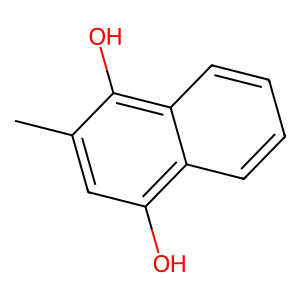

In [43]:
test_molecule = Chem.MolFromSmiles(list(test_smiles.keys())[2])
Draw.MolToImage(test_molecule)  # 2D

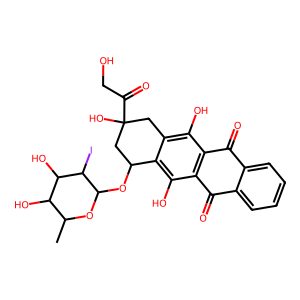

In [44]:
test_molecule = Chem.MolFromSmiles(list(test_smiles.keys())[3])
Draw.MolToImage(test_molecule)  # 2D

The original code used ```test_fingerprint = AllChem.GetMorganFingerprintAsBitVect()```, but Python returned a **```DEPRECATION WARNING: please use MorganGenerator```** –therefore the ```rdFingerprintGenerator``` package was instead used:

In [45]:
fingerprint_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=4096)
test_fingerprint = fingerprint_gen.GetFingerprint(test_molecule)
test_bitstring = test_fingerprint.ToBitString()
print(f"Here are the first 997 characters from the ECFP bitvector: {test_bitstring[:997]}")

Here are the first 997 characters from the ECFP bitvector: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000

As you can see above, RDKit objects and ECFP bitvectors cannot be stored in a table in a human-readable way, therefore the subfunctions were not even required just to be able to convert them, as the conversion itself just requires one line from the ```Chem``` module. 

Here instead a test for the ```compute_similarity()``` function:

In [46]:
test_simTable, test_id = compute_similarity(test_smiles)
print(test_simTable)

[[1.         0.07792208 0.09090909 0.07142857]
 [0.07792208 1.         0.06944444 0.11214953]
 [0.09090909 0.06944444 1.         0.12      ]
 [0.07142857 0.11214953 0.12       1.        ]]


In [47]:
print(test_id)

[{'id': 'chembl:CHEMBL12856', 'label': 'INAMRINONE'}, {'id': 'chembl:CHEMBL2103869', 'label': 'DASOLAMPANEL'}, {'id': 'chembl:CHEMBL1405447', 'label': 'VITAMIN K3H2'}, {'id': 'wikidata:Q4767903', 'label': 'ANNAMYCIN'}]


In order to properly have 1 on the diagonal (self-similarity), the similarity table was initialised with ```np.ones()``` **instead of CR's ```np.zeros()```** which would lead to a misinterpretation of the results thinking that by 0 being the most similar, then scores had to be inverted by multiplying them for ```-1``` –unless CR meant to turn this into a dissimilarity matrix, but names and descriptions in the functions point to a misunderstanding instead. This was then 'fixed' by again erroneously assuming that weights should be re-multiplied by ```-1``` when buildijng the graph dataframe.

Just to be clear, the *Tanimoto coefficient* is just another application for ***Jaccard's index***, which here is the ratio between how many bits are ```1``` in both fingerprints (*i.e.* intersection ∣A∩B∣) and how many bits are ```1``` in at least one of them (*i.e.* union ∣A∪B∣).

In [48]:
def generate_drug_edges(similarity_matrix,sorted_matrix,ids,K,minimum=0.5):
    '''
    This function builds the edges object from the similarity matrix.

    :param similarity_matrix: similarity matrix from compute_similarity()
    :param sorted_matrix: result of KNN on similarity matrix 
    :param ids: list of ids from compute_similarity()
    :param K: number of top scoring drugs based on similarity
    :param min_simil: minimum similarity score
    :return: drug-to-drug edges
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    similarity = []
    added_edges_count = 0
    skipped_edges_count = 0
    chunk_size = 2000
    num_chunks = (similarity_matrix.shape[0] // chunk_size) + 1

    for chunk in range(num_chunks):
        start_idx = chunk * chunk_size
        end_idx = min((chunk + 1) * chunk_size, similarity_matrix.shape[0])
        
        sub_similarity_matrix = similarity_matrix[start_idx:end_idx, :]
        sub_sorted_matrix = sorted_matrix[start_idx:end_idx, :]
        sub_ids = ids[start_idx:end_idx]

        # further update to remove all ==1 and if so, raise K+ how many times ==1
        for i in range(sub_similarity_matrix.shape[0]):
            global_i = start_idx + i  # Adjust index for the original matrix
            for j in sub_sorted_matrix[i, :K]:
                # filter results below the 'min_simil' threshold (default = 0.5)
                # and those at 0 even if 'min_simil == 0.0', as well as any isoform with == 1.0 other than identity
                if sub_similarity_matrix[i, j] >= minimum and sub_similarity_matrix[i, j] != 0 and sub_similarity_matrix[i, j] != 1:
                    new_row = [
                        {'id': ids[global_i]['id'], 'label': ids[global_i]['label']},
                        {'label': 'smiles: similar to'},
                        {'id': ids[j]['id'], 'label': ids[j]['label']},
                        {'notes': f'similarity score: {sub_similarity_matrix[i, j]}'}
                    ]
                    similarity.append(new_row)
    
    return similarity
    

def run_drugsimilarity(monarch_input,date,K=10,min_simil=None,input_radius=None,input_length=None):
    '''
    This function runs the whole drug_similarioty script and saves nodes and edges files.

    :param monarch_input: the input seed from the run_monarch() step
    :param date: the date of creation of the disease graph
    :param K: number of top scoring drugs based on similarity
    :param min_simil: minimum similarity score
    :param input_radius: any value that would override default radius=2 in compute_similarity()
    :param input_length: any value that would override default length=4096 in compute_similarity()
    :return: list of edges with drug-to-drug associations
    '''

    start_time = time.time()
    
    logging.info(f"NOW RUNNING: {current_function_name()} following 'run_dgidb({monarch_input},{today},layers={run_layers})'.")

    global nodes
    global edges
    global drug_nodes

    drugSimil_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'drug_similarity')
    os.makedirs(drugSimil_directory, exist_ok=True)
    
    # convert drug IDs into SMILES notations
    nodes_list = [(node['id'], node['label']) for node in nodes]
    alldrug_list = [(drug_node['id'], drug_node['label']) for drug_node in drug_nodes]
    smiles = get_smiles(nodes_list)
    alldrug_smiles = get_smiles(alldrug_list)
    
    # save SMILES notations as CSV
    smiles_data = [{'SMILES': k, 'ID': v['id'], 'Label': v['label']} for k, v in smiles.items()]
    smiles_df = pd.DataFrame(smiles_data)
    smiles_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date}_drugSim_smiles.csv'), index=False)
    alldrugs_smiles_data = [{'SMILES': k, 'ID': v['id'], 'Label': v['label']} for k, v in alldrug_smiles.items()]
    alldrugs_smiles_df = pd.DataFrame(alldrugs_smiles_data)
    alldrugs_smiles_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date}_alldrugSim_smiles.csv'), index=False)

    # compute similarities
    similarities, id_list = compute_similarity(smiles,radius=input_radius,length=input_length)
    alldrug_simil, alldrug_id_list = compute_similarity(alldrug_smiles,radius=input_radius,length=input_length)
    
    # save the similarity matrix as CSV
    ids = [d['id'] for d in id_list]
    similarities_df = pd.DataFrame(similarities, index=ids, columns=ids)
    similarities_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date}_drugSim_similarityMatrix.csv'), index=True)
    alldrug_ids = [d['id'] for d in alldrug_id_list]
    alldrug_simil_df = pd.DataFrame(alldrug_simil, index=alldrug_ids, columns=alldrug_ids)
    alldrug_simil_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date}_alldrugSim_similarityMatrix.csv'), index=True)
    
    # sort based on similarity scores (ignore identity, first element for any sorting)
    # later on remove and handle in generate_drug_edges()
    sortedSimilarities = np.argsort(-similarities, axis=1)[:, 1:K+1]
    alldrug_sorted = np.argsort(-alldrug_simil, axis=1)[:, 1:K+1]
    
    # generate drug-to-drug edges
    drug_similarity = generate_drug_edges(similarities,sortedSimilarities,id_list,K,minimum=min_simil)
    drug_edges = generate_drug_edges(alldrug_simil,alldrug_sorted,alldrug_id_list,K,minimum=min_simil)

    # MERGE new edges with the existing ones
    all_edges = edges + drug_similarity
    unique_edges = unique_elements(all_edges)
    unique_drug_edges = unique_elements(drug_edges)

    # save the unique edges as CSV
    edges_df = pd.DataFrame(unique_edges)
    edges_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date_str}_drugSim_edges.csv'), index=False)
    drug_edges_df = pd.DataFrame(drug_edges)
    drug_edges_df.to_csv(os.path.join(drugSimil_directory, f'{disease_name_label}_{date_str}_alldrugSim_edges.csv'), index=False)
    
    logging.info("CSV files saved in drug_similarity directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"'drugsimilarity.py' run finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"'drugsimilarity.py' run finished in {minutes} minutes and {seconds} seconds.")

    return unique_edges, unique_drug_edges

The macro-function **```run_drugsimilarity()```** adds a series of optional parameters that allow to change ```radius```, ```length``` (for the ECFP bitvector generation)  and ```K``` (for the Tanimoto coefficient), while still setting default parameters (*i.e.* radius = 2,length = 4096,K = 10) directly in function ```compute_similarity()``` which uses them.

This could allow for an implementation in the flaskApp that would enable competent users to set these parameters manually.

CR's original code referenced property ```CHEMINF:000481``` (*i.e.* 'similar to') which seems not to exist anymore: 

![](./PIPELINE_images/cheminf_000481-1.png)

![](./PIPELINE_images/cheminf_000481-2.png)

According to [*Fu et al. 2015*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4500850/), ```CHEMINF:000482``` and ```CHEMINF:000483``` where meant to respectively represent 2D and 3D similarity, but I could not find informations on ```CHEMINF:000481```. Moreover, the platform that developed it seems to no longer exist –at least to that given URL.

![](./PIPELINE_images/cheminf_000481-4.png)

![](./PIPELINE_images/cheminf_000481-3.png)

More recent works such as [*Pascazio et al. 2023*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10647085/) seem to suggest that ```CHEMINF:``` identifiers are no longer used, while also showing that SPARQL is a viable option to obtain semantic information on chemical structures –similarly to how I modified the SMILES-fetching lines for ```wikidata:``` molecules.

In the end –similarly to how ```RO:``` OWL identifiers are no longer supported by Monarch, so I had to remove them– I will ignore the ```CHEMINF:``` IDs that CR added to the edge object for drug-to-drug similarity associations and stick to a simpler ```[{'id': 'MONDO:0016621', 'label': 'juvenile Huntington disease'}, {'label': 'biolink:subclass_of'}, {'id': 'MONDO:0007739', 'label': 'Huntington disease'}, {'notes': 'second_layer'}]``` structure where each dictionary represents only **```subj,relation,obj,notes```**.

The last dictionary (*i.e.* ```notes```) will store relavant information for the edge based on the source of the data: **```Monarch.py```** populates it with the layer of the call (*i.e.* ```'first_layer'```, ```'second_layer'``` and ```'third_layer'```), **```DGIdb.py```** populates it with the 'quality' of the match (*i.e.* ```'matchedTerms'``` and ```'ambiguousTerms'```), and the current **```drug_similarity.py```** stores similarity scores in it –an information that was not reported by CR's original code, and which I instead deem to be relevant.

Below a test run of macro-function ```run_drugsimilarity()```:

In [49]:
# to load 'nodes', 'edges' from dataframe CSV files
# since re-running 'run_dgidb()' takes a lot of time
dgidb_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'dgidb')
os.makedirs(dgidb_directory, exist_ok=True)

nodes_path = os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_nodes.csv')
nodes_df = pd.read_csv(nodes_path)
nodes = nodes_df.to_dict(orient='records')

edges_path = os.path.join(dgidb_directory, f'{disease_name_label}_{date_str}_dgidb_edges.csv')
edges_df = pd.read_csv(edges_path)
edges = []
for _, row in edges_df.iterrows():
    subj = ast.literal_eval(row.iloc[0])
    rel = ast.literal_eval(row.iloc[1])
    obj = ast.literal_eval(row.iloc[2])
    notes = ast.literal_eval(row.iloc[3])
    edges.append([subj, rel, obj, notes])

drug_nodes_path = os.path.join(dgidb_directory, 'all_drugs', f'{disease_name_label}_{date_str}_dgidb_all_drugs.csv')
drug_nodes_df = pd.read_csv(drug_nodes_path)
drug_nodes = drug_nodes_df.to_dict(orient='records')

In [50]:
input_min_simil = 0.3
edges, drug_edges = run_drugsimilarity(input_seed,today,min_simil=input_min_simil)

'drugsimilarity.py' run finished in 1 minutes and 13 seconds.


In [51]:
len(edges)

17684

In [52]:
len(nodes)

9991

The number of nodes didn't change, while the edges went **from 4.377 to 9.336**. Moreover, this step in the pipeline seems to be extremely fast, as the ```get_things``` and ```SPARQL``` packages' calls can manage multiple queries –therefore only one call is done for each of them.

![](./PIPELINE_images/cheminf_000481-5.jpg)

In [53]:
rel_counts = {}
for edge in edges:
    rel = edge[1]
    if 'label' in rel:
        rel_type = rel['label']
        if rel_type in rel_counts:
            rel_counts[rel_type] += 1
        else:
            rel_counts[rel_type] = 1
print(rel_counts)

{'biolink:has_mode_of_inheritance': 287, 'biolink:subclass_of': 1729, 'biolink:related_to': 525, 'biolink:has_phenotype': 3825, 'biolink:causes': 202, 'biolink:gene_associated_with_condition': 328, 'biolink:treats_or_applied_or_studied_to_treat': 304, 'biolink:interacts_with': 4209, 'biolink:enables': 135, 'biolink:actively_involved_in': 122, 'biolink:located_in': 101, 'biolink:participates_in': 714, 'biolink:orthologous_to': 94, 'biolink:contributes_to': 37, 'biolink:acts_upstream_of_or_within': 11, 'biolink:expressed_in': 90, 'biolink:active_in': 9, 'biolink:colocalizes_with': 2, 'biolink:acts_upstream_of': 2, 'dgidb:interacts_with': 3484, 'smiles: similar to': 1474}


Just as confirmation: **```9336 - 4959 = 4377```**, where we have 4.959 counts for ```'smiles: similar to'``` as drug-to-drug associations.

In [54]:
len(drug_nodes)

53048

In [55]:
len(drug_edges)

13774

Above we can see instead that the network of all the drugs from DGIdb based on similarity has **43.808 edges** with similarity of at least 30%.

In the future I would want to try implementing a version using [**Alpha Fold**'s V2 API](https://alphafold.com/api-docs), but I couldn't find any existing approach to obtain an ECFP from Alpha Fold's 3D prediction. The [new V3 version](https://golgi.sandbox.google.com) is available now –[*Abramson et al. 2023*](https://www.nature.com/articles/s41586-024-07487-w) paper is still under review as of today (May 10th 2024)– but no API is available, and the model is not open source: it's token-based, and any API probably will require an API key to couple accesses to a paid account.

The V2 model though is still very viable. I will investigate on how to obtain ECFP from that.

## 5. ```combine_graphs.py```: MERGING GRAPHS

This section of CR's original code can be skipped: it was made in order to join nodes and edges obtained from each of the three previous steps (*i.e.* ```Monarch.py```, ```DGIdb.py``` and ```drugsimilarity.py```) by reading the dataframe ```.csv``` files, merging the ```pandas``` dataframes and removing non-unique nodes and edges -to then finally once again save them as ```.csv```files.

This version of the pipeline does not require that: objects ```nodes``` and ```edges``` are updated at each steps with all new nodes and edges, while intermediate version (*i.e.* Monarch, then Monarch+DGIdb, and finally Monarch+DGIdb+Similarities) are stored in ```.csv``` files for archival reasons: they can be opened and information in ```notes:``` as well as the prefix in ```relation:``` (*i.e.* ```biolink:``` for biological associations, ```dgidb:``` for gene-to-drug associations, and ```smiles:``` for drug-to-drug associations) can show which step they come from. Moreover, ```pandas``` dataframes allow for ```pd.concat([df_2, df_1, df_1]).drop_duplicates(keep=False)``` subtraction to find rows in ```df_2``` that aren't in ```df_1```.

In the end the code can easily run just by handling data also in non-dataframe formats: this pipeline easily handles **```nodes```** as a list of dictionaries where ```keys='id:','label:'``` –as in the ontology ID and name of any given biological element– and **```edges```** as lists of lists of dictionaries ```[subj,rel,obj,notes]``` where ```subj``` and ```obj``` are just nodes dictionaries in the same format described earlies, and ```rel``` and ```notes``` are dictionaries with ```key='label'``` respectively storing information on the relation type and extra information (*i.e.* layes of the Monarch call, type of gene-to-drug match, and similarity scores).

The next step involves unsupervised machine learning, **but the script does not require CR's original data structure**, as it still will only extrapolate the IDs of the nodes and the type or relation to build an RDF –all information that can also be accessed from this pipeline's data-structure. Thus all metadata added by CR's original code are ignored in the learning step, which is good as they could no longer be fetched from Monarch's V3 API –and they were manually added in the other two steps.

## 6. ```network_model.py```: NETWORK UNSUPERVISED LEARNING

CR's approach in file ```rdf2vec.py``` to this section was to first merge again all .csv files within macro-function **```rdf2vec_general()```** (input = symptom ID from the old ```run_monarch_symptom()``` function, date, and string with information on disease-name-date; output = None) to then create a series of data structures:
1. an **RDF graph that does not include drug-gene interactions** via ```csv_to_rdf()``` (input = path to the edges file, path to the nodes file, dictionary mapping node types to URIs; output = string RDF in turtle-format (*i.e.* .ttl file))
2. **RDF embeddings** (as vectors) **of only-gene and only-drug nodes** via ```rdf_to_vec()``` (input = path to the nodes file, path to drug similarity file, string RDFF in turtle-format, target entity type to vectorise ('gene' by default); output = dictionary with ```keys = entities``` ('gene' by default) and ```values = vector embeddings```)
3. **a list of genes of interest** associated to the input phenotype via ```get_genes_of_interest()``` (input = dataframe of Monarch edges, dataframe of Monarch nodes, symptom ID from the old ```run_monarch_symptom()``` function; output = list of gene URIs)
4. **dataframes for the training and prediction subsets of edges** via ```fuse_embeddings()```  (input = RDF embedding of genes, RDF embedding of drugs, path to drug edges file, path to graph node data, list of gene URIs; output = training dataframe, prediction dataframe)

Then function **```ml_prediction()```** (input = training dataframe, prediction dataframe, current date; output = dataframe of predicted interactions) would handle both the model training and the prediction of drugs associated to the input disease (*e.g.* ```MONDO:0007739```). These drugs are then ranked via ```drug_list_rank()``` (input = symptom ID from the old ```run_monarch_symptom()``` function, string with information on disease-name-date, the dataframe of predicted interactions, and default minimum probability score of 0.9; output = html page with the resulting predictions table).

![](./PIPELINE_images/xgboost.png)

CR's approach leads to a conceptual error: apparently this approach is not possible. When investigating I realised that package ```pyrdf2vec``` requires a version of ```torch``` that cannot be ealier than 1.8.1 or equal/later than 2.0.0 —yet versions of ```torch``` earlier than 2.0.0 are no longer supporter and especially not available on PyPi. I would then suggest NOT using them. 

Since RDFs are not required for the purpose of drug-repurposing, they will be bypassed right now and eventually re-implemented in the future along with OWL relational ontologies (*i.e.* ```RO:```) and chemical ontologies.

Embeddings will be created directly from the network via the **Node2Vec** algorithm in package ```node2vec``` instead.

In [56]:
nodeType_counts = {}
for node in nodes:
    if 'id' in node:
        nodeType = node['id'].split(':')[0]
        if nodeType in nodeType_counts:
            nodeType_counts[nodeType] += 1
        else:
            nodeType_counts[nodeType] = 1
print(nodeType_counts)

{'HGNC': 3020, 'MONDO': 1332, 'drugbank': 125, 'PATO': 6, 'rxcui': 867, 'GO': 323, 'HP': 1342, 'chembl': 908, 'ncit': 540, 'NCBIGene': 118, 'MGI': 117, 'CHEBI': 578, 'WB': 64, 'FB': 47, 'iuphar.ligand': 173, 'UBERON': 107, 'ZFIN': 42, 'UPHENO': 66, 'Reactome': 102, 'RGD': 46, 'MP': 4, 'CL': 12, 'NCBITaxon': 9, 'SGD': 3, 'Xenbase': 14, 'PomBase': 5, 'dictyBase': 7, 'ECTO': 3, 'PR': 4, 'hemonc': 1, 'CHR': 2, 'OBA': 1, 'SO': 1, 'wikidata': 2}


Above the node types present in the first two layers. Function ```get_network()``` (input = list of nodes, list of edges and eventually any node type to exclude; output = networkX object) use a custom dictionary that converts URIs into nodetypes, also taking into accounts ortholog gene URI (*e.g.* ```ZFIN:```).

In [57]:
node_type_dict = {
        'disease': ['MONDO'],
        'gene': ['HGNC', 'MGI', 'GO', 'NCBIgene', 'ZFIN', 'Xenbase'],
        'phenotype': ['HP'],
        'drug': ['chembl', 'wikidata']
    }

In [58]:
def get_network(input_nodes,input_edges,exclude=None):
    '''
    This function builds a network object from lists of nodes and edges in a
    given format. Examples:
    
    NODES = [{'id': 'chembl:CHEMBL348436', 'label': 'CIRSIMARITIN'},
    {'id': 'chembl:CHEMBL1503190', 'label': 'CHEMBL1503190'},...]
    
    EDGES = [[{'id': 'MONDO:0007739', 'label': 'Huntington disease'},
    {'label': 'biolink:has_mode_of_inheritance'},
    {'id': 'HP:0000006', 'label': 'Autosomal dominant inheritance'},
    {'notes': 'first_layer'}],[{'id': 'MONDO:0007739', 'label': 'Huntington disease'},
    {'label': 'biolink:subclass_of'},
    {'id': 'MONDO:0005395', 'label': 'movement disorder'},
    {'notes': 'first_layer'}]...]
    
    It can remove a given edge type in order to build a partial network: it should be
    in the URI format (e.g. 'dgidb:'), and the formula checks if it's in the entire
    relations label.

    :param input_nodes: list of nodes
    :param input_edges: list of edges
    :param exclude: edge type to exclude (default = None) 
    :return: networkX object
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    G = nx.DiGraph()

    global node_type_dict

    node_type_colours = {
        'disease': '#00008b',  # darkblue
        'gene': '#add8e6',     # lightblue
        'phenotype': '#0000ff',# blue
        'drug': '#ff0000',     # red
        'else': '#ffa500'      # orange
    }

    edge_type_colours = {
        'biolink': '#0000ff',  # blue
        'dgidb': '#ff0000',    # red
        'SMILES': '#ff4500',   # lightred
        'xgboost': '#00ff00'   # green 
    }
    
    # add nodes
    for node in input_nodes:
        node_id = node['id']
        label = node['label']
        node_type = 'else'
        
        for type_key, prefixes in node_type_dict.items():
            if any(node_id.startswith(prefix + ':') for prefix in prefixes):
                node_type = type_key
                break
                
        G.add_node(node_id, label=label, node_type=node_type, colour=node_type_colours[node_type])
    
    # add edges
    for edge in input_edges:
        subj_id = edge[0]['id']
        obj_id = edge[2]['id']
        rel_label = edge[1]['label']
        notes = edge[3]['notes']
        
        if exclude is not None and exclude in rel_label:
            continue  # skip this edge if exclusion criteria match
        
        rel_type = rel_label.split(':')[0]
        colour = edge_type_colours.get(rel_type, '#000000')  # default to black if not found
        G.add_edge(subj_id, obj_id, label=rel_label, notes=notes, colour=colour)

    return G
    

def get_embeddings(input_network,node_type_select=None):
    '''
    This function builds embeddings (vectors) for node informations -also considering
    the edges they are involved in- from a network object via Node2Vec.
    It can filter to a selected type of nodes

    :param input_network: networkX object
    :param node_type_select: node type to focus on (default = None)
    :return: embedding pickle object
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    global network_directory, node_type_dict
    valid_node_types = set(node_type_dict.keys())
    
    if node_type_select and node_type_select not in valid_node_types:
        raise ValueError(f"Invalid node_type_select: {node_type_select}. Valid options are: {valid_node_types}")

    # (eventually) filter nodes
    if node_type_select:
        nodes_to_include = [node for node in input_network.nodes() if input_network.nodes[node].get('node_type') == node_type_select]
        subgraph = input_network.subgraph(nodes_to_include)
    else:
        subgraph = input_network

    # generate node embeddings using Node2Vec
    node2vec = Node2Vec(subgraph, dimensions=64, walk_length=30, num_walks=200, workers=2)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    output_embeddings = {node: model.wv[node] for node in subgraph.nodes()}

    # save the embeddings dictionary to a PKL file
    if node_type_select is not None:
        embedding_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_embedding_dict_{node_type_select}.pkl')
    else:
        embedding_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_embedding_dict_full.pkl')
    with open(embedding_path, "wb") as file:
        pickle.dump(output_embeddings, file)

    return output_embeddings

Below a test of how the new network structure and visualisation is:

/var/folders/qc/jcjqr7ds64l399ssmnk89w4c0000gn/T/ipykernel_25990/876486475.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(test_network, pos, width=0.2, alpha=0.2, edge_color=edge_colors)


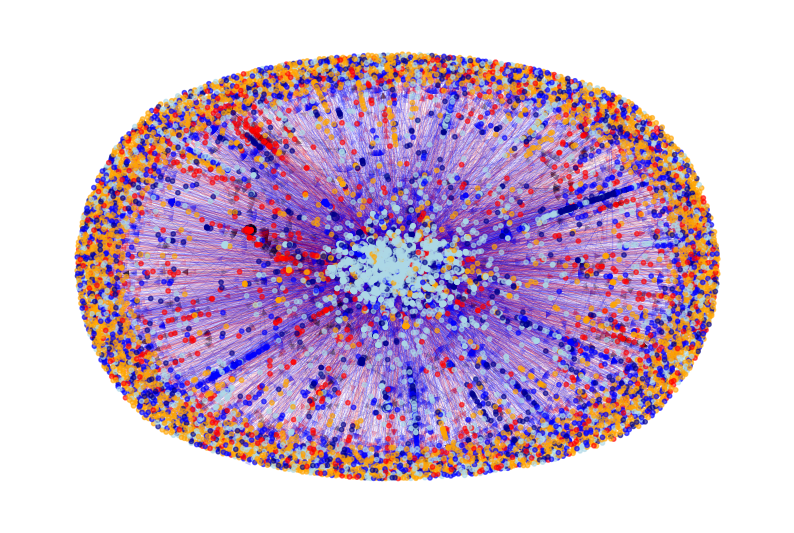

In [59]:
test_network = get_network(nodes,edges)

pos = nx.spring_layout(test_network)
ordered_node_colors = [test_network.nodes[node]['colour'] for node in test_network.nodes()]
node_sizes = [30 if node == 'MONDO:0007739' else 10 for node in test_network.nodes()]
plt.figure(figsize=(3000/300, 2000/300))  # 300dpi
nx.draw_networkx_nodes(test_network, pos, node_size=node_sizes, node_color=ordered_node_colors, alpha=0.6)
edge_colors = [test_network[u][v]['colour'] for u, v in test_network.edges()]
nx.draw_networkx_edges(test_network, pos, width=0.2, alpha=0.2, edge_color=edge_colors)
plt.axis('off')

network_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'network')
os.makedirs(network_directory, exist_ok=True)

plot_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_network_plot.png')
plt.savefig(plot_path, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

In [60]:
print(test_network)

DiGraph with 9991 nodes and 17684 edges


Then next the same network without edges between gene and drugs:

/var/folders/qc/jcjqr7ds64l399ssmnk89w4c0000gn/T/ipykernel_25990/2388806245.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(test_network_partial, pos, width=0.2, alpha=0.2, edge_color=edge_colors)


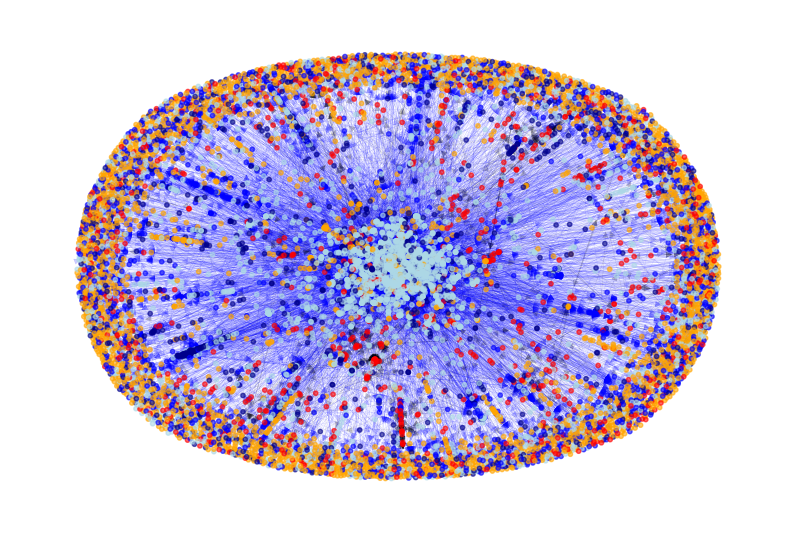

In [61]:
test_network_partial = get_network(nodes,edges,exclude='dgidb')

pos = nx.spring_layout(test_network_partial)
ordered_node_colors = [test_network_partial.nodes[node]['colour'] for node in test_network_partial.nodes()]
node_sizes = [30 if node == 'MONDO:0007739' else 10 for node in test_network_partial.nodes()]
plt.figure(figsize=(3000/300, 2000/300))  # 300dpi
nx.draw_networkx_nodes(test_network_partial, pos, node_size=node_sizes, node_color=ordered_node_colors, alpha=0.6)
edge_colors = [test_network_partial[u][v]['colour'] for u, v in test_network_partial.edges()]
nx.draw_networkx_edges(test_network_partial, pos, width=0.2, alpha=0.2, edge_color=edge_colors)
plt.axis('off')

plot_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_network_plot_partial.png')
plt.savefig(plot_path, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

Here instead the network of all the drugs in DGIdb: 

/var/folders/qc/jcjqr7ds64l399ssmnk89w4c0000gn/T/ipykernel_25990/308634298.py:9: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(test_network_drugsonly, pos, width=0.2, alpha=0.2, edge_color=edge_colors)


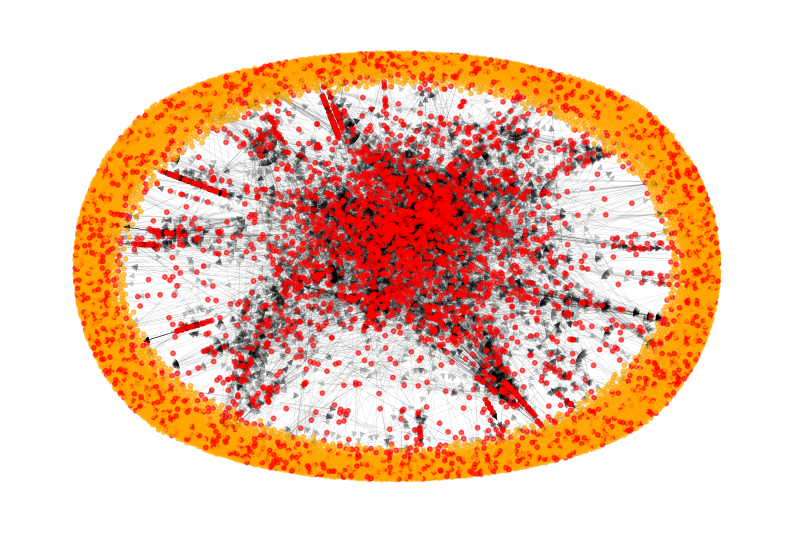

In [62]:
test_network_drugsonly = get_network(drug_nodes,drug_edges)

pos = nx.spring_layout(test_network_drugsonly)
ordered_node_colors = [test_network_drugsonly.nodes[node]['colour'] for node in test_network_drugsonly.nodes()]
node_sizes = [30 if node == 'MONDO:0007739' else 10 for node in test_network_drugsonly.nodes()]
plt.figure(figsize=(3000/300, 2000/300))  # 300dpi
nx.draw_networkx_nodes(test_network_drugsonly, pos, node_size=node_sizes, node_color=ordered_node_colors, alpha=0.6)
edge_colors = [test_network_drugsonly[u][v]['colour'] for u, v in test_network_drugsonly.edges()]
nx.draw_networkx_edges(test_network_drugsonly, pos, width=0.2, alpha=0.2, edge_color=edge_colors)
plt.axis('off')

plot_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_network_plot_drugsonly.png')
plt.savefig(plot_path, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

And finally the entire network of associations to ```MONDO:0007743``` and all drugs from DGIdb:

/var/folders/qc/jcjqr7ds64l399ssmnk89w4c0000gn/T/ipykernel_25990/3050133550.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(test_network_entire, pos, width=0.2, alpha=0.2, edge_color=edge_colors)


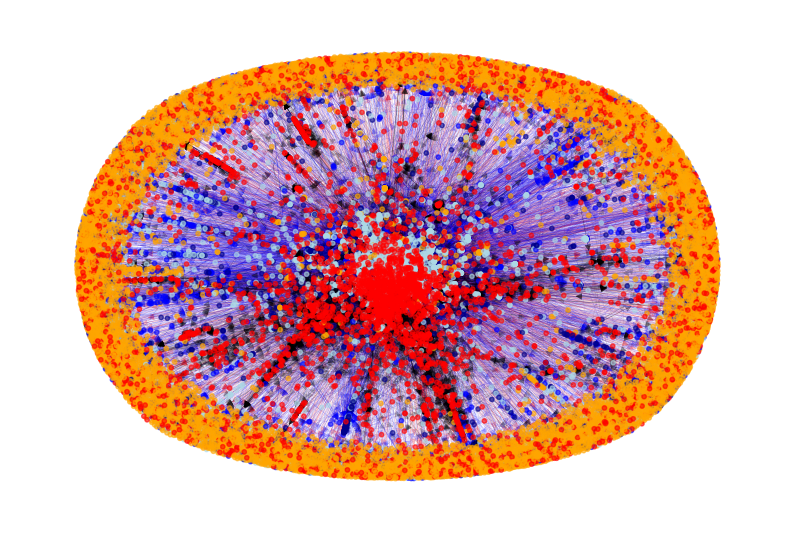

In [63]:
all_nodes = nodes + drug_nodes
all_edges = edges + drug_edges
test_network_entire = get_network(all_nodes,all_edges)

pos = nx.spring_layout(test_network_entire)
ordered_node_colors = [test_network_entire.nodes[node]['colour'] for node in test_network_entire.nodes()]
node_sizes = [30 if node == 'MONDO:0007739' else 10 for node in test_network_entire.nodes()]
plt.figure(figsize=(3000/300, 2000/300))  # 300dpi
nx.draw_networkx_nodes(test_network_entire, pos, node_size=node_sizes, node_color=ordered_node_colors, alpha=0.6)
edge_colors = [test_network_entire[u][v]['colour'] for u, v in test_network_entire.edges()]
nx.draw_networkx_edges(test_network_entire, pos, width=0.2, alpha=0.2, edge_color=edge_colors)
plt.axis('off')

plot_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_network_plot_entire.png')
plt.savefig(plot_path, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

Below instead the test for ```get_embeddings()``` (input = networkX object, nodetype to focus on; output = embeddings pickle object) which retrieves the embedding vector for a given network:

In [64]:
test_embeddings = get_embeddings(test_network)

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:03<00:00, 29.45it/s]


In [65]:
test_gene_embeddings = get_embeddings(test_network,node_type_select='gene')

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:01<00:00, 72.42it/s]


In [66]:
test_drug_embeddings = get_embeddings(test_network,node_type_select='drug')

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:00<00:00, 280.99it/s]


Below instead the **```fuse_embeddings()```** function (input = _____; output = ______) which is used to obtain the training and prediction dataframes to used in function ```ml_prediction()``` (input = _____; output = _____).

In [67]:
def fuse_embeddings(gene_embedding_dict, drug_embedding_dict, alldrug_embedding_dict, DGIdb_edges_list, nodes_list, alldrug_nodes_list):
    '''
    This function fuses the embeddings for the genes and drugs that have a known link,
    and adds additional drug-gene pairs with random non-known links for prediction.
    Structure of embedding dictionaries: {key: gene/drug, value: embedding}

    :param gene_embedding_dict: all gene embeddings associated to 'input_seed'
    :param drug_embedding_dict: all drug embeddings associated to 'input_seed'
    :param alldrug_embedding_dict: all drug embeddings with entire 'DGIdb'
    :param DGIdb_edges_list: list of gene-to-drug edges from 'run_dgidb()'
    :param nodes_list: list of nodes associated to 'input_seed'
    :param alldrug_nodes_list: list of nodes with entire 'DGIdb'
    :return: dataframes used to train the XGboost model, and subsequently test it
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    array_drugs = np.array(list(drug_embedding_dict.keys()))
    array_alldrugs = np.array(list(alldrug_embedding_dict.keys()))
    array_genes = np.array(list(gene_embedding_dict.keys()))

    DGIdb_edges_df = pd.DataFrame({
        'subject_id': [edge[0]['id'] for edge in DGIdb_edges_list],
        'object_id': [edge[2]['id'] for edge in DGIdb_edges_list],
        'relation': [edge[1]['label'] for edge in DGIdb_edges_list]
    })

    def is_interaction_present(gene_id, drug_id):
        return (
            ((DGIdb_edges_df['subject_id'] == gene_id) & (DGIdb_edges_df['object_id'] == drug_id))
            | ((DGIdb_edges_df['subject_id'] == drug_id) & (DGIdb_edges_df['object_id'] == gene_id))
        ).any()

    # Create gene-to-drug interaction dataframe for training
    train_rows = []

    for gene in array_genes:
        gene_emb = gene_embedding_dict[gene]
        for drug in array_drugs:
            fused_emb = np.multiply(gene_emb, drug_embedding_dict[drug])
            class_label = 1 if is_interaction_present(gene, drug) else 0
            train_rows.append({
                'gene': gene, 'drug': drug, 'fused_embedding': fused_emb, 'class': class_label
            })
    train_df = pd.DataFrame(train_rows)

    # Create interaction dataframe for prediction with additional drugs
    predict_rows = []

    for gene in array_genes:
        gene_emb = gene_embedding_dict[gene]
        for drug in array_alldrugs:
            fused_emb = np.multiply(gene_emb, alldrug_embedding_dict[drug])
            predict_rows.append({
                'gene': gene, 'drug': drug, 'fused_embedding': fused_emb, 'class': np.nan
            })
    predict_df = pd.DataFrame(predict_rows)

    # Save the training and prediction dataframes to CSV files
    train_df_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_training_df.csv')
    train_df.to_csv(train_df_path, index=False)
    predict_df_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_prediction_df.csv')
    predict_df.to_csv(predict_df_path, index=False)

    return train_df, predict_df

Below a test of the ```fuse_embeddings()``` function:

In [68]:
full_network = get_network(nodes,edges)
partial_alldrug_network = get_network(drug_nodes,drug_edges,exclude='dgidb:')
    
drug_embeddings = get_embeddings(full_network,node_type_select='drug')
alldrug_embeddings = get_embeddings(partial_alldrug_network,node_type_select='drug')
gene_embeddings = get_embeddings(full_network,node_type_select='gene')

DGIdb_edges = [edge for edge in edges if 'dgidb' in edge[1]['label']]

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:01<00:00, 69.36it/s]


In [69]:
training_df, prediction_df = fuse_embeddings(gene_embeddings,drug_embeddings,alldrug_embeddings,DGIdb_edges,nodes,drug_nodes)

In [70]:
unique_classes, counts = np.unique(training_df['class'],return_counts=True)
print("Unique classes in train_df['class']:", unique_classes)
print("Counts of each class in train_df['class']:", dict(zip(unique_classes, counts)))

Unique classes in train_df['class']: [0 1]
Counts of each class in train_df['class']: {0: 3198467, 1: 1093}


In [71]:
len(DGIdb_edges)

3484

And finally the **```ml_prediction()```** function which runs the XGboost unsupervised learning model:

In [72]:
def ml_prediction(train_df, predict_df,input_jobs=(num_cores//2),depth='full',random_seed=123):
    '''
    This function builds a unsupervised learning model using as training data 
    the network of interactions between biological associations (via 'Monarch.py'),
    gene-to-drug associations (via 'DGIdb.py'), and drug-to-drug similarity (via
    'drug_similarity.py') –to then predict new interactions.
    
    :param train_df: dataframe of (gene, drug, embedding, class) used for training
    :param predict_df: dataframe of (gene, drug, embedding, class) used for prediction
    :param input_jobs: how many CPU cores to use ('-1' uses all available)
    :param depth: based on this, different sets of parameters, splits, repeats and iterations
    are performed (default = 'full', factor of 'full', 'light' and 'ultralight')
    :param random_seed: seed to have consistent results (default = 123)
    :return: dataframe of newly predicted interactions
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    global nodes
    global drug_nodes

    print('ML model is being trained, be patient.')
    ml_train_start_time = time.time()

    # MODEL TRAINING
    # X = embeddings (turn list of embeddings into columns)
    emb_col = train_df['fused_embedding']
    X = pd.DataFrame(emb_col.tolist())
    X = X.astype(float)
    
    # y = labels
    y = train_df['class'].astype(int)
    unique_classes = np.unique(y)

    # define parameters to be tuned, and model
    if depth == 'full':
        parameters = {
            'min_child_weight': [2, 3, 5, 8, 13, 20, 30],
            'gamma': [0, 0.2, 0.5, 0.8, 1.2, 1.6, 2.5, 4, 6],
            'reg_alpha': [0, 0.5, 1, 3, 5, 10],
            'reg_lambda': [0, 0.5, 1, 3, 5, 10],
            'subsample': uniform(0.5, 0.5),  # = uniform distribution on (0.5, 1)
            'colsample_bytree': uniform(0.2, 0.8),  # = uniform distribution on (0.2, 1)
            'max_depth': [4, 6, 8, 10, 12, 14, 16],
            'n_estimators': [35, 45, 50, 70, 80, 90, 100],
            'learning_rate': uniform(0, 0.3),
        }
        n_s = 10  # number of splits
        n_r = 5  # number of repeats
        n_i = 20  # number of iterations
    elif depth == 'light':
        parameters = {
            'min_child_weight': [3, 8, 20],
            'gamma': [0.5, 1.2, 2.5],
            'reg_alpha': [1, 5],
            'reg_lambda': [1, 5],
            'subsample': [0.5],
            'colsample_bytree': [0.7],
            'max_depth': [3, 5],
            'n_estimators': [10, 20, 30],
            'learning_rate': [0.1],
        }
        n_s = 3  # number of splits
        n_r = 2  # number of repeats
        n_i = 5  # number of iterations
    elif depth == 'ultralight':
        parameters = {
            'min_child_weight': [5, 20],
            'gamma': [0.5, 2.5],
            'reg_alpha': [1, 5],
            'reg_lambda': [1, 5],
            'subsample': [0.5],
            'colsample_bytree': [0.7],
            'max_depth': [3, 5],
            'n_estimators': [10, 20],
            'learning_rate': [0.1],
        }
        n_s = 2  # number of splits
        n_r = 1  # number of repeats
        n_i = 5  # number of iterations
    xgb_model_hyp = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss',num_class=len(unique_classes),random_state=random_seed)

    # find the best hyperparameters using repeated stratified k-fold and randomized search
    rskf = RepeatedStratifiedKFold(n_splits=n_s, n_repeats=n_r, random_state=random_seed)
    randomized_search = RandomizedSearchCV(xgb_model_hyp, param_distributions=parameters,
                                           scoring='f1_weighted', n_iter=n_i, n_jobs=input_jobs,
                                           error_score='raise', cv=rskf.split(X, y), verbose=1,
                                           refit=True)  # refit: train with best hyperparameters found
    # make sure weights for training are added to avoid unbalanced training
    weight = class_weight.compute_sample_weight('balanced', y)
    randomized_search.fit(X, y, sample_weight=weight)

    # report best parameters and best model (scores)
    print('best found hyperparameters:', randomized_search.best_params_)
    print('score of the model:', randomized_search.best_score_)

    ml_train_end_time = time.time()
    duration = ml_train_end_time - ml_train_start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"XGBoost model training finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"XGBoost model training finished in {minutes} minutes and {seconds} seconds.")
    
    print('Prediction is being made, be patient.')
    ml_predict_start_time = time.time()
    
    # INTERACTION PREDICTION
    emb_col_pred = predict_df['fused_embedding']
    X_pred = pd.DataFrame(emb_col_pred.tolist())
    X_pred = X_pred.astype(float)
    predictions = randomized_search.predict(X_pred)
    predictions_prob = randomized_search.predict_proba(X_pred)
    interaction_predictions_df = pd.DataFrame(
        {'drug': predict_df['drug'],
         'gene': predict_df['gene'],
         'predicted_interaction': predictions,
         'prob': np.max(predictions_prob, axis=1)
         })
    
    # add labels to the drugs and genes for better readability
    all_nodes = nodes + drug_nodes
    id_to_label = {node['id']: node['label'] for node in all_nodes}

    interaction_predictions_df['drug'] = interaction_predictions_df['drug'].apply(
        lambda drug_uri: f'<a href="{drug_uri}">{id_to_label.get(drug_uri, drug_uri)}</a>'
    )
    interaction_predictions_df['gene'] = interaction_predictions_df['gene'].apply(
        lambda gene_uri: f'<a href="{gene_uri}">{id_to_label.get(gene_uri, gene_uri)}</a>'
    )
    
    # save output files
    interaction_predictions_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_predicted_df.csv')
    interaction_predictions_df.to_csv(interaction_predictions_path, index=False)

    ml_predict_end_time = time.time()
    duration = ml_predict_end_time - ml_predict_start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"XGBoost model prediction finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"XGBoost model prediction finished in {minutes} minutes and {seconds} seconds.")

    return interaction_predictions_df

In [73]:
num_jobs = 4
depth_input = 'ultralight'
predicted_df = ml_prediction(training_df,prediction_df,input_jobs=num_jobs,depth=depth_input)

ML model is being trained, be patient.
Fitting 2 folds for each of 5 candidates, totalling 10 fits
best found hyperparameters: {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 10, 'min_child_weight': 20, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.7}
score of the model: 0.9867502004938278
XGBoost model training finished in 1 minutes and 17 seconds.
Prediction is being made, be patient.
XGBoost model prediction finished in 17 minutes and 8 seconds.


The test above for function **```ml_prediction()```** (input = dataframe to train on, dataframe to predict on, number of CPU cores to use, set of parameters to use; ouput = dataframe of predictions) is very quick and oversimplified, just to be able to process the remaining data. The full run takes instead 1000 fits, being extremely more intensive on the CPU anyway (even with just 2 cores out of 10, it overclocks them to 400% maximum vCPU).

Below the distribution of associations made:

In [74]:
num_ones = (predicted_df['predicted_interaction'] == 1).sum()
num_zeros = (predicted_df['predicted_interaction'] == 0).sum()
print("Number of 1s (interactions predicted):", num_ones)
print("Number of 0s (no interactions predicted):", num_zeros)

Number of 1s (interactions predicted): 708106
Number of 0s (no interactions predicted): 15243986


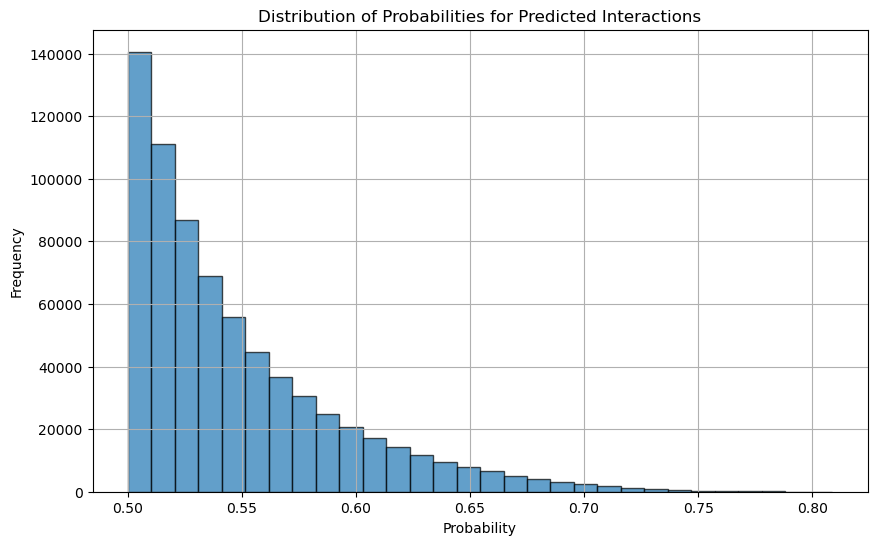

In [75]:
interaction_df = predicted_df[predicted_df['predicted_interaction'] == 1]
interaction_probs = interaction_df['prob']
plt.figure(figsize=(10, 6))
plt.hist(interaction_probs, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Probabilities for Predicted Interactions')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [76]:
filtered_df = predicted_df[(predicted_df['predicted_interaction'] == 1) & (predicted_df['prob'] >= 0.65)]
num_ones_high_prob = len(filtered_df)
print("Number of 1s (interactions predicted) with prob >= 0.65:", num_ones_high_prob)

Number of 1s (interactions predicted) with prob >= 0.65: 30024


In [77]:
filtered_df = predicted_df[(predicted_df['predicted_interaction'] == 1) & (predicted_df['prob'] >= 0.70)]
num_ones_high_prob = len(filtered_df)
print("Number of 1s (interactions predicted) with prob >= 0.70:", num_ones_high_prob)

Number of 1s (interactions predicted) with prob >= 0.70: 6815


This first test run lead to a grand total of **```430.224```** associations, which get down to ```1.258``` and ```74``` if we only consider those respectively with at least 65% and 70% of probability.

**ADD A SEED** to make results consistent.

In [78]:
filtered_df = predicted_df[(predicted_df['predicted_interaction'] == 1) & (predicted_df['prob'] >= 0.65)]
drug_counts = filtered_df['drug'].value_counts()
print("Number of predicted associations for each drug:")
print(drug_counts)

Number of predicted associations for each drug:
drug
<a href="chembl:CHEMBL4297624">BISEGLIPTIN</a>                   407
<a href="chembl:CHEMBL4650315">DESMETRAMADOL</a>                 404
<a href="chembl:CHEMBL4297288">HYDRONIDONE</a>                   325
<a href="chembl:CHEMBL242385">CHEMBL:CHEMBL242385</a>            318
<a href="chembl:CHEMBL579318">CHEMBL:CHEMBL579318</a>            254
                                                                ... 
<a href="chembl:CHEMBL532849">CHEMBL:CHEMBL532849</a>              1
<a href="chembl:CHEMBL1210769">CHEMBL:CHEMBL1210769</a>            1
<a href="chembl:CHEMBL463686">PHENAZINE-1-CARBOXYLIC ACID</a>      1
<a href="chembl:CHEMBL118378">CHEMBL:CHEMBL118378</a>              1
<a href="chembl:CHEMBL527584">CHEMBL:CHEMBL527584</a>              1
Name: count, Length: 2223, dtype: int64


In [79]:
gene_counts = filtered_df['gene'].value_counts()
print("\nNumber of predicted associations for each gene:")
print(gene_counts)


Number of predicted associations for each gene:
gene
<a href="HGNC:6893">MAPT</a>        972
<a href="HGNC:644">AR</a>           583
<a href="HGNC:4851">HTT</a>         564
<a href="HGNC:11405">BRSK2</a>      555
<a href="HGNC:4616">GSK3A</a>       505
                                   ... 
<a href="HGNC:12703">BEST1</a>        1
<a href="HGNC:253">ADH5</a>           1
<a href="HGNC:23068">TRAPPC2</a>      1
<a href="HGNC:6349">KLF5</a>          1
<a href="HGNC:238">ADCY7</a>          1
Name: count, Length: 1697, dtype: int64


Below function **```filter_rank_drugs()```** (input = ____; output = ____) which replaces CR's original ```drug_list_rank()``` (input = ____; output = ____) adding a step that removes gene-to-drug associations that were already know and ranks the remaining based on node centrality (*i.e.* both the most central and the least central were tested) and prediction confidence reported in column ```prob``` of ```ml_prediction()```'s output:

In [80]:
def extract_id_label(href):
    '''
    Simple function to extrapolate 'id' and 'label' from href in 'prefict_df'.

    :param href: long string for 'id' and 'label' combined
    :return: 'id', and 'label' short strings
    '''
    
    id_match = re.search(r'<a href="([^"]+)">', href)
    label_match = re.search(r'<a href="[^"]+">([^<]+)</a>', href)
    
    return id_match.group(1), label_match.group(1)


def filter_rank_drugs(predict_df,prob_threshold=0.65,cluster_threshold=0.8):
    '''
    This function filters predicted drug-gene interactions based on probability
    and ranks drugs based on their interactions with genes.
    
    :param predict_df: dataframe containing predictions with columns 
        ['drug', 'gene', 'predicted_interaction', 'prob']
    :param prob_threshold: probability threshold for filtering predictions
    :param cluster_threshold: cluster threshold for ranking drugs
    :return: ranked list of drugs with counter, and list of predicted edges
    '''

    logging.info(f"NOW RUNNING: {current_function_name()}.")
    
    global nodes
    
    # filter the dataframe
    filt_df = predict_df[(predict_df['predicted_interaction'] == 1) & (predict_df['prob'] >= prob_threshold)]
    
    # remove any drug already present in 'nodes'
    nodes_set = {node['id'] for node in nodes}
    new_df = filt_df[~filt_df['drug'].isin(nodes_set)]
    
    # rank drugs based on how many genes each drug interacts with
    drug_counts = new_df['drug'].value_counts()
    max_count = drug_counts.max()
    threshold_count = max_count * cluster_threshold
    ranked_drugs = drug_counts[drug_counts >= threshold_count].index.tolist()

    # create the ranked list with counts
    ranked_list = [{'id': drug_id, 'label': drug_label, 'count': drug_counts[drug_href]} 
                   for drug_href in ranked_drugs 
                   for drug_id, drug_label in [extract_id_label(drug_href)]]
    
    # create a ranked dataframe
    ranked_df = new_df[new_df['drug'].isin(ranked_drugs)]
    
    # build the list of new 'edges'
    id_to_label = {node['id']: node['label'] for node in nodes}
    predict_edges = []
    for _, row in ranked_df.iterrows():
        gene_href = row['gene']
        drug_href = row['drug']
        gene_id, gene_label = extract_id_label(gene_href)
        drug_id, drug_label = extract_id_label(drug_href)
        
        edge = [
            {'id': gene_id, 'label': gene_label},
            {'label': 'xgboost:has_association'},
            {'id': drug_id, 'label': drug_label},
            {'notes': row['prob']}
        ]
        predict_edges.append(edge)
    
    return ranked_list, predict_edges

In [81]:
ranked_drug_list, predicted_edges = filter_rank_drugs(predicted_df)
predicted_edges[:3]

[[{'id': 'HGNC:23513', 'label': 'USP54'},
  {'label': 'xgboost:has_association'},
  {'id': 'chembl:CHEMBL4297624', 'label': 'BISEGLIPTIN'},
  {'notes': 0.6964631676673889}],
 [{'id': 'HGNC:1773', 'label': 'CDK4'},
  {'label': 'xgboost:has_association'},
  {'id': 'chembl:CHEMBL4650315', 'label': 'DESMETRAMADOL'},
  {'notes': 0.6582033634185791}],
 [{'id': 'HGNC:12680', 'label': 'VEGFA'},
  {'label': 'xgboost:has_association'},
  {'id': 'chembl:CHEMBL4297624', 'label': 'BISEGLIPTIN'},
  {'notes': 0.6876872777938843}]]

In [82]:
ranked_drug_list

[{'id': 'chembl:CHEMBL4297624', 'label': 'BISEGLIPTIN', 'count': 407},
 {'id': 'chembl:CHEMBL4650315', 'label': 'DESMETRAMADOL', 'count': 404}]

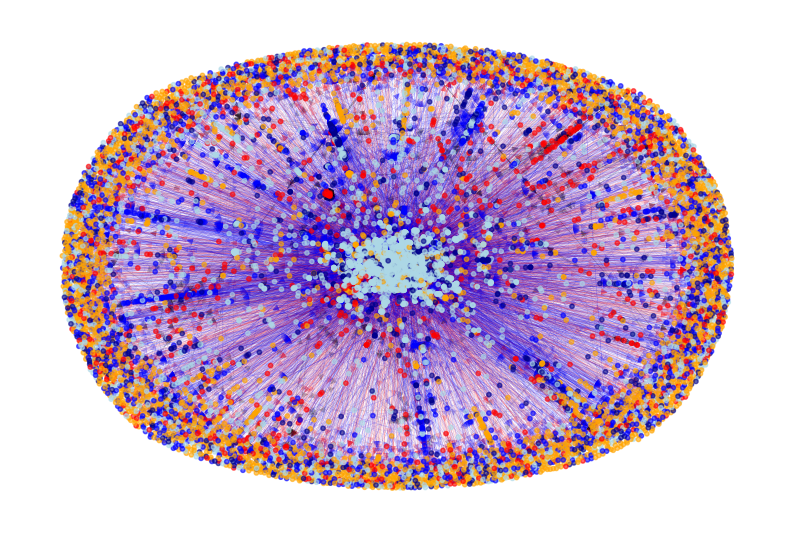

In [83]:
full_edges = edges + drug_edges + predicted_edges
full_nodes = [edge[0] for edge in full_edges] + [edge[2] for edge in full_edges]
full_nodes = unique_elements(full_nodes)

full_network = get_network(full_nodes,full_edges)

pos = nx.spring_layout(test_network)
ordered_node_colors = [test_network.nodes[node]['colour'] for node in test_network.nodes()]
node_sizes = [30 if node == 'MONDO:0007739' else 10 for node in test_network.nodes()]
plt.figure(figsize=(3000/300, 2000/300))  # 300dpi
nx.draw_networkx_nodes(test_network, pos, node_size=node_sizes, node_color=ordered_node_colors, alpha=0.6)
for u, v, data in test_network.edges(data=True):
    edge_color = data['colour']
    if edge_color == '#00ff00':  # Adjust the properties for the green edges
        nx.draw_networkx_edges(test_network, pos, edgelist=[(u, v)], width=0.8, alpha=0.5, edge_color=edge_color)
    else:  # Default properties for other edges
        nx.draw_networkx_edges(test_network, pos, edgelist=[(u, v)], width=0.2, alpha=0.2, edge_color=edge_color)
plt.axis('off')
plot_path = os.path.join(network_directory, f'{disease_name_label}_{date_str}_full_network_plot.png')
plt.savefig(plot_path, format="png", dpi=300, bbox_inches='tight', pad_inches=0.1)

Finally below macro-function **```network_model()```** (input = ____; output = ____) which runs all the steps involving training the model and making predictions based on the outputs of previous steps (*i.e.* ```Monarch.py```, ```DGIdb.py``` and ```drug_similarity.py```):

In [84]:
def run_network_model(monarch_input,date,run_jobs=None,run_depth=None,run_seed=None):
    '''
    This function runs the entire network_model script and saves nodes and edges files
    after a prediction made via XGBoost.

    :param monarch_input: the input seed from the run_monarch() step
    :param date: the date of creation of the disease graph
    :param input_jobs: 
    :param input_depth: 
    :param input_seed: 
    :return: 
    '''

    start_time = time.time()
    
    logging.info(f"NOW RUNNING: {current_function_name()} following 'drug_similarity({monarch_input},{today},min_simil={input_min_simil})'.")
    
    global nodes, edges, drug_nodes, drug_edges

    node_type_dict = {
        'disease': ['MONDO'],
        'gene': ['HGNC', 'MGI', 'GO', 'NCBIgene', 'ZFIN', 'Xenbase'],
        'phenotype': ['HP'],
        'drug': ['chembl', 'wikidata']
    }
    
    network_directory = os.path.join(today_directory, f'{disease_name_label} ({date_str})', 'network')
    os.makedirs(network_directory, exist_ok=True)

    full_network = get_network(nodes,edges)
    partial_alldrug_network = get_network(drug_nodes,drug_edges,exclude='dgidb:')
    
    drug_embeddings = get_embeddings(full_network,node_type_select='drug')
    alldrug_embeddings = get_embeddings(partial_alldrug_network,node_type_select='drug')
    gene_embeddings = get_embeddings(full_network,node_type_select='gene')

    logging.info("PKL files saved in network directory.")

    DGIdb_edges = [edge for edge in edges if 'dgidb' in edge[1]['label']]
    training_df, prediction_df = fuse_embeddings(gene_embeddings,drug_embeddings,alldrug_embeddings,DGIdb_edges,nodes,drug_nodes)
    
    predicted_df = ml_prediction(training_df, prediction_df,input_jobs=run_jobs,depth=run_depth,random_seed=run_seed)

    ranked_drug_list, predicted_edges = filter_rank_drugs(predicted_df)
    for ranked_drug_elem in ranked_drug_list:
        logging.info(f"{ranked_drug_elem['count']} new edge(s) for drug {ranked_drug_elem['id']}.")
        print(f"{ranked_drug_elem['count']} new edge(s) for drug {ranked_drug_elem['id']}.")
    
    full_edges = edges + drug_edges + predicted_edges
    full_nodes = [edge[0] for edge in full_edges] + [edge[2] for edge in full_edges]
    full_nodes = unique_elements(full_nodes)

    # save nodes and edges as CSV
    full_edges_df = pd.DataFrame(full_edges)
    full_edges_df.to_csv(os.path.join(network_directory, f'{disease_name_label}_{date_str}_fullnetwork_edges.csv'), index=False)
    full_nodes_df = pd.DataFrame(full_nodes)
    full_nodes_df.to_csv(os.path.join(network_directory, f'{disease_name_label}_{date_str}_fullnetwork_nodes.csv'), index=False)
    
    logging.info("CSV files saved in network directory.")

    end_time = time.time()
    duration = end_time - start_time  # calculate duration in seconds
    minutes = int(duration // 60)  # convert seconds to whole minutes
    seconds = int(duration % 60)  # get the remaining seconds
    print(f"'network_model.py' run finished in {minutes} minutes and {seconds} seconds.")
    logging.info(f"'network_model.py' run finished in {minutes} minutes and {seconds} seconds.")
    
    return full_edges, full_nodes, ranked_drug_list

In [85]:
num_jobs = 4
depth_input = 'light'
network_edges, network_nodes, ranked_drugs = run_network_model(input_seed,today,run_jobs=num_jobs,run_depth=depth_input)

Generating walks (CPU: 2): 100%|██████████| 100/100 [00:01<00:00, 72.37it/s]


ML model is being trained, be patient.
Fitting 6 folds for each of 5 candidates, totalling 30 fits
best found hyperparameters: {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 10, 'min_child_weight': 20, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 2.5, 'colsample_bytree': 0.7}
score of the model: 0.9854680344391289
XGBoost model training finished in 2 minutes and 20 seconds.
Prediction is being made, be patient.
XGBoost model prediction finished in 16 minutes and 59 seconds.
106 new edge(s) for drug chembl:CHEMBL1256708.
91 new edge(s) for drug chembl:CHEMBL2163795.
89 new edge(s) for drug chembl:CHEMBL462731.
'network_model.py' run finished in 101 minutes and 59 seconds.


Below the code snippet checking for the entire duration of the pipeline to this point:

In [86]:
overall_end_time = time.time()
overall_duration = overall_end_time - overall_start_time  # calculate duration in seconds
minutes = int(overall_duration // 60)  # convert seconds to whole minutes
seconds = int(overall_duration % 60)  # get the remaining seconds
print(f"PIPELINE run finished in {minutes} minutes and {seconds} seconds.")
logging.info(f"PIPELINE run finished in {minutes} minutes and {seconds} seconds.")

PIPELINE run finished in 267 minutes and 20 seconds.


## 7. NEGATIVE LINKS IN ```network_model.py``` (updated)

![](./PIPELINE_images/hubert_et_al-1.png)

Following having solved all the issues with CR's faulty tool, I proceed to **add the 'negative links' step** in the pipeline –based on [Hubert et al. 2024](https://link.springer.com/chapter/10.1007/978-3-031-60626-7_2) ([**github** repository](https://github.com/nicolas-hbt/semantic-lossfunc)) and enrichment of loss of function via embedding in RDFs.

## 8. ```routes.py```: DOCKER IMAGE / FLASK APP

Lastly:
- place the HTML sections in file ```routes.py```, not in single function files
- define which **parameters** would be set in the FlaskApp (*e.g.* seed, how many layers...)